In [1]:
# Librerías estándar y de terceros
import os
import sys
import gc
import math as m
import numpy as np
import scipy
import pandas as pd
import pylab
from scipy import *
from scipy.signal import butter, filtfilt, hilbert
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
# Configuración de rutas para importaciones personalizadas
sys.path.append('/projects/DEIKE/cmartinb/jupyter_notebook/project_specific/turbulence')
sys.path.append('/projects/DEIKE/cmartinb/functions')
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Funciones y clases personalizadas
from prepare import load_object, save_object, field
from defs import Case, Interface2D
from phase import extract_phase
from funciones import *  # Asegúrate de que la importación con * sea necesaria, a veces es mejor importar solo las funciones necesarias
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
os.chdir('/projects/DEIKE/cmartinb/')

variance =[]
integral = []
polar_integral = []

kp = 4; omegap = (1*kp)**0.5

def spectrum_integration(eta, N,L,CHECK=False):
    
    """ 
    Input : 
        - eta
        - N : number of points
        - L : length domain
    
    Ouput :
        - k , kx , ky , theta : wavenumber vector , his components in x and y , angle theta 
        - F_center: F(kx, ky)
        - F_center_polar: F(k,theta)
        - F_center_polar_integrated : F(k) (azimuthal integration of the 2D spectrum)
        - k_tile , theta_tile : mesh in (k,theta)
        - kxp_tile, kyp_tile : mesh in (kx,ky) from (k,theta)
        - variance, integral, polar_integral : list for checking 
    
    """
    
    varr =  np.var(eta)
    if CHECK: print('var', varr)
    #variance.append(varr)
    
    #print('mean', np.mean(eta))
    
    wavenumber =  2*np.pi*np.fft.fftfreq(N,L/N)
    kx = np.fft.fftshift(wavenumber); ky = kx
    kx_tile, ky_tile = np.meshgrid(kx,ky)
    
    theta = np.linspace(-np.pi,np.pi, 100)
    
    #xs = 2*m.pi ; ys=xs
    #rmax = (xs**2 + ys**2)**0.5
    #radii = np.linspace(0, rmax, 100, endpoint=True)
    
    
    k = wavenumber[0:int(N/2)]
    dkx = kx[1] - kx[0]; dky = ky[1] - ky[0]
    dk = k[1]-k[0]; dtheta = theta[1]-theta[0]
    
    spectrum = np.fft.fft2(eta/(N*N)**0.5) # FFT normalization 
    F = np.absolute(spectrum)**2/N**2/(dkx*dky) # Per area normalization -> F(kx,ky)
    
    if CHECK: print ('sum F', np.sum(F))
    F_center = np.fft.fftshift(F,axes=(0,1)) # Further normalization by independent variables
    
    k_tile, theta_tile = np.meshgrid(k,theta)
    kxp_tile, kyp_tile = pol2cart(k_tile, theta_tile)
    
    
    
    integ = np.sum(F_center)*dkx*dky # F
    if CHECK: print('integral',integ)
    #integral.append(integ)
    
    
    F_center_polar = scipy.interpolate.griddata((kx_tile.ravel(),ky_tile.ravel()), F_center.ravel(), (kxp_tile, kyp_tile), method='nearest', fill_value=0) #F(k,theta)
    
    F_center_polar_integrated = np.sum(F_center_polar*k_tile, axis=0)*dtheta # Azimuthal integration
    int_pol = np.sum(F_center_polar_integrated)*dk # F
    if CHECK: print ('sum polar integrated', int_pol)
    
    
    if CHECK: print('F center', F_center.shape , 'F polar', F_center_polar.shape , 'F center polar integrated' , F_center_polar_integrated.shape)
    
    #polar_integral.append(int_pol)
    
    return k, F_center, F_center_polar_integrated , F_center_polar , k_tile, kxp_tile, kyp_tile , theta_tile , theta , varr, integ, int_pol , kx, ky

In [2]:
# DEFINE CASE SO WE CAN AUTHOMATIZE IT 
kpHs = '0p16' # 0p16 
uoc = '0p50' # 0p50 0p75
reW = '2.5e4' #1.0e5
reA = 720
#maxLevel = 10
maxLevel = 10
Bo=200


In [3]:
if reW == '1.0e5':
    Re_water = 1 * 10**5
else:
    Re_water = 2.5 * 10**4

if maxLevel == 11:
    N = 1024
else:
    N = 512 

#Common parameters 
kp = 4
u = 0.25
lambdap = 2*m.pi/kp

rho1 = 1
rho2 = 1.25*10**(-3)

L0 = 2*np.pi;

ak,  c, omegap, nu_water, g, uoc_val, sigma, Tp= calculate_parameters(kpHs, uoc , u ,kp, Bo, rho1, rho2)
print('ak is', ak, 'c is' ,c, 'w_p$ is', omegap, '$\nu_w$ is' , nu_water, 'g is' ,g, 'N', N)

ak is 0.16 c is 0.5 w_p$ is 2.0 $
u_w$ is 3.141592653589793e-05 g is 0.9950310636260177 N 512


In [4]:
# Cargar eta_series desde un archivo .npy
#maxLevel = 10
maxLevel = 10

if reW == '1.0e5':
    Re_water = 1 * 10**5
else:
    Re_water = 2.5 * 10**4

if maxLevel == 11:
    N = 1024
else:
    N = 512 

eta_series_L10 = np.load(f'/projects/DEIKE/cmartinb/eta/eta_series_re{reA}_bo0{Bo}_P{kpHs}_uoc{uoc}_reW{reW}_L{maxLevel}.npy', allow_pickle=True)
print(eta_series_L10.shape)

work_dir_L10 =  f'/projects/DEIKE/nscapin/broadband_reorder/re{reA}_bo0{Bo}_P{kpHs}_uoc{uoc}_reW{reW}_L{maxLevel}/'

# Leer el archivo de texto
data_L10 = np.loadtxt(work_dir_L10+'eta/global_int.out')

# Obtener la segunda columna
istep_c_L10 =data_L10[:, 1]
#print(istep_c.shape[0])
time_L10 = data_L10[:,0] 
#print(time)

(1246, 512, 512)


In [5]:
# Cargar eta_series desde un archivo .npy

maxLevel = 11

if reW == '1.0e5':
    Re_water = 1 * 10**5
else:
    Re_water = 2.5 * 10**4

if maxLevel == 11:
    N = 1024
else:
    N = 512 
eta_series_L11 = np.load(f'/projects/DEIKE/cmartinb/eta/eta_series_re{reA}_bo0{Bo}_P{kpHs}_uoc{uoc}_reW{reW}_L{maxLevel}.npy', allow_pickle=True)
print(eta_series_L11.shape)

work_dir_L11 =  f'/projects/DEIKE/nscapin/broadband_reorder/re{reA}_bo0{Bo}_P{kpHs}_uoc{uoc}_reW{reW}_L{maxLevel}/'

# Leer el archivo de texto
data_L11 = np.loadtxt(work_dir_L11+'eta/global_int.out')

# Obtener la segunda columna
istep_c_L11 =data_L11[:, 1]
#print(istep_c.shape[0])
time_L11 = data_L11[:,0] 
#print(time)

(939, 1024, 1024)


In [12]:
graph_path = f'/projects/DEIKE/cmartinb/notebooks/graphs/stability/'
if not os.path.exists(graph_path):
    os.makedirs(graph_path)

In [7]:

#initialization of lists for checking

variance =[]
integral = []
polar_integral = []

kp = 4; omegap = (1*kp)**0.5

def spectrum_integration(eta, N,L,CHECK=False):
    
    """ 
    Input : 
        - eta
        - N : number of points
        - L : length domain
    
    Ouput :
        - k , kx , ky , theta : wavenumber vector , his components in x and y , angle theta 
        - F_center: F(kx, ky)
        - F_center_polar: F(k,theta)
        - F_center_polar_integrated : F(k) (azimuthal integration of the 2D spectrum)
        - k_tile , theta_tile : mesh in (k,theta)
        - kxp_tile, kyp_tile : mesh in (kx,ky) from (k,theta)
        - variance, integral, polar_integral : list for checking 
    
    """
    
    varr =  np.var(eta)
    if CHECK: print('var', varr)
    #variance.append(varr)
    
    #print('mean', np.mean(eta))
    
    wavenumber =  2*np.pi*np.fft.fftfreq(N,L/N)
    kx = np.fft.fftshift(wavenumber); ky = kx
    kx_tile, ky_tile = np.meshgrid(kx,ky)
    
    theta = np.linspace(-np.pi,np.pi, 100)
    
    #xs = 2*m.pi ; ys=xs
    #rmax = (xs**2 + ys**2)**0.5
    #radii = np.linspace(0, rmax, 100, endpoint=True)
    
    
    k = wavenumber[0:int(N/2)]
    dkx = kx[1] - kx[0]; dky = ky[1] - ky[0]
    dk = k[1]-k[0]; dtheta = theta[1]-theta[0]
    
    spectrum = np.fft.fft2(eta/(N*N)**0.5) # FFT normalization 
    F = np.absolute(spectrum)**2/N**2/(dkx*dky) # Per area normalization -> F(kx,ky)
    
    if CHECK: print ('sum F', np.sum(F))
    F_center = np.fft.fftshift(F,axes=(0,1)) # Further normalization by independent variables
    
    k_tile, theta_tile = np.meshgrid(k,theta)
    kxp_tile, kyp_tile = pol2cart(k_tile, theta_tile)
    
    
    
    integ = np.sum(F_center)*dkx*dky # F
    if CHECK: print('integral',integ)
    #integral.append(integ)
    
    
    F_center_polar = scipy.interpolate.griddata((kx_tile.ravel(),ky_tile.ravel()), F_center.ravel(), (kxp_tile, kyp_tile), method='nearest', fill_value=0) #F(k,theta)
    
    F_center_polar_integrated = np.sum(F_center_polar*k_tile, axis=0)*dtheta # Azimuthal integration
    int_pol = np.sum(F_center_polar_integrated)*dk # F
    if CHECK: print ('sum polar integrated', int_pol)
    
    
    if CHECK: print('F center', F_center.shape , 'F polar', F_center_polar.shape , 'F center polar integrated' , F_center_polar_integrated.shape)
    
    #polar_integral.append(int_pol)
    
    return k, F_center, F_center_polar_integrated , F_center_polar , k_tile, kxp_tile, kyp_tile , theta_tile , theta , varr, integ, int_pol , kx, ky

<>:92: SyntaxWarning: invalid escape sequence '\o'
<>:96: SyntaxWarning: invalid escape sequence '\o'
<>:101: SyntaxWarning: invalid escape sequence '\m'
<>:102: SyntaxWarning: invalid escape sequence '\m'
<>:92: SyntaxWarning: invalid escape sequence '\o'
<>:96: SyntaxWarning: invalid escape sequence '\o'
<>:101: SyntaxWarning: invalid escape sequence '\m'
<>:102: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_88410/2563109306.py:92: SyntaxWarning: invalid escape sequence '\o'
  cbar.set_label('$\omega_{p} t$')
/tmp/ipykernel_88410/2563109306.py:96: SyntaxWarning: invalid escape sequence '\o'
  cbar.set_label('$\omega_{p} t$')
/tmp/ipykernel_88410/2563109306.py:101: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('$\mathdefault{k/k_{p}}$')
/tmp/ipykernel_88410/2563109306.py:102: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('$\mathdefault{\Phi(k)}$')
/tmp/ipykernel_88410/2563109306.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecate

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: 

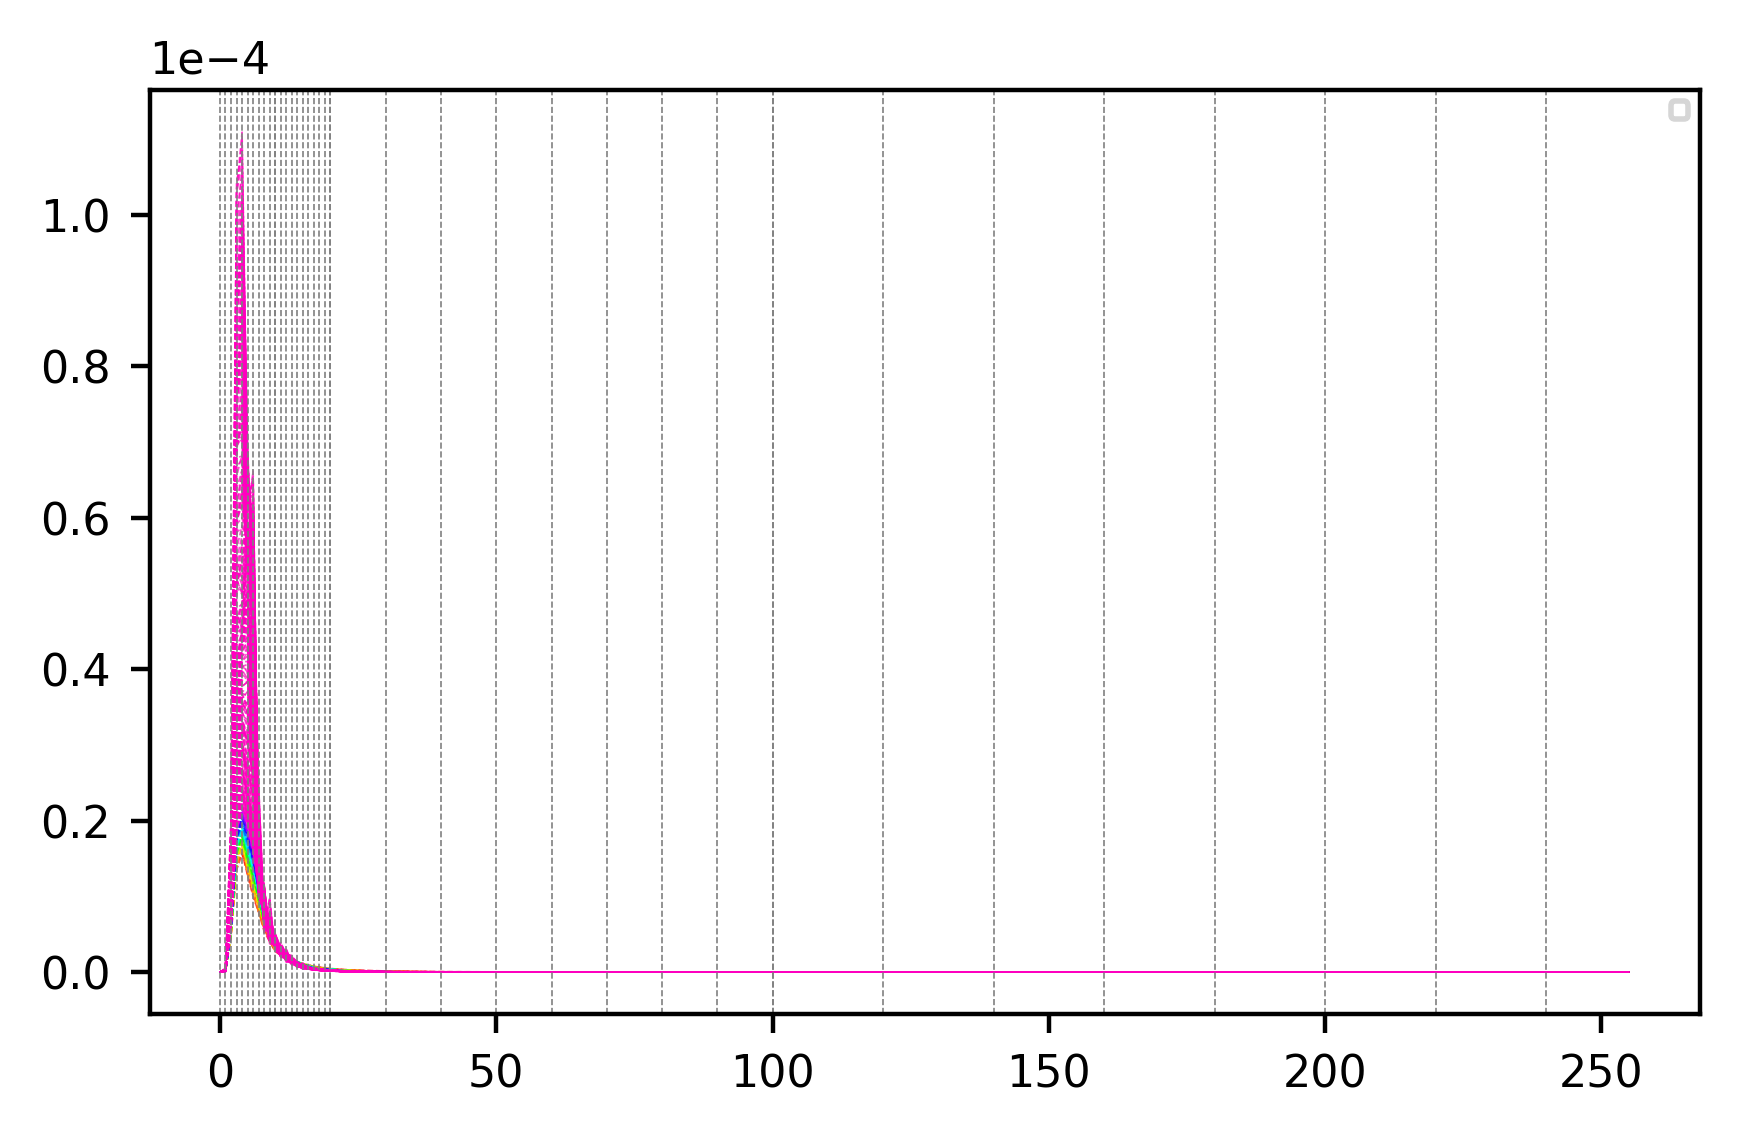

In [8]:
import matplotlib.cm as cm
from scipy.interpolate import interp1d
color_map = plt.cm.gist_rainbow
fig = plt.figure(figsize=[5, 3])
ax = fig.gca()

num_rows = 2
num_cols = 3

kp = 4

N = 512
L = 2 * np.pi

j = 0




variance_L10 = []
integral_L10 = []
polar_integral_L10 = []

# modes growth
energy_mode_L10 = []
coordx_mode_L10 = []

filtered_coordx_mode = []
filtered_energy_mode = []

for i in range(len(eta_series_L10)):
    eta = eta_series_L10[i]

    k, F_center, F_center_polar_integrated, F_center_polar, k_tile, kxp_tile, kyp_tile, theta_tile, theta, variance, integral, polar_integral, kx, ky = spectrum_integration(
        eta - np.mean(eta), N, L, CHECK=False)
    dk = k[1] - k[0]
    #print(k)
    if i == 0:

        indices1 = np.arange(0, np.where(k >= 1)[0][0], max(1, int(0.25 / dk)))
        indices10 = np.arange(np.where(k >= 1)[0][0], np.where(k >= 10)[0][0], max(1, int(1 / dk)))
        indices1020 = np.arange(np.where(k >= 10)[0][0], np.where(k > 20)[0][0], max(1, int(1 / dk)))
        indices100 = np.arange(np.where(k >= 10)[0][0], np.where(k > 100)[0][0], max(1, int(10/ dk)))
        indicesplus = np.arange(np.where(k >= 100)[0][0], len(k), max(1, int(20 / dk)))

        k_multiples = np.concatenate((indices1, indices10, indices1020 ,indices100, indicesplus))

        k_multiples = k_multiples.astype(int)
        # Obtener los valores de k y las energías correspondientes
        k_seleccionados = k[k_multiples]

    energias_correspondientes_L10 = F_center_polar_integrated[k_multiples]

    
    if i == 0:
        E0_both_L10 = np.sum(F_center_polar_integrated) * dk
        #print(type(indices_cada_diez))
        E0_nodes_both = F_center_polar_integrated[k_multiples]
        #E0_second_both =  F_center_polar_integrated[k_second]
    
    if i % 5 == 0:
        psd = ax.plot(k, F_center_polar_integrated, '--', color=plt.cm.get_cmap('gist_rainbow')(j), alpha=0.7, linewidth=0.3)
    
    
    energy_mode_L10.append(energias_correspondientes_L10.tolist())
    #coordx_mode.append(coordx.tolist())
    
    integral_L10.append(integral)
    j += 1

# plot where are the nodes

for km in k_seleccionados:
    plt.axvline(x=km, color='gray', linestyle='--', linewidth=0.3)
    
ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.legend(loc='upper right', fontsize=4)


color_values =  (np.array(time_L10)-time_L10[0])

# Now set the normalization with the correct range

norm = plt.Normalize(vmin=color_values.min(), vmax=color_values.max())
sm = plt.cm.ScalarMappable(cmap=color_map, norm=norm)
sm.set_array([])  

# Add the colorbar to the figure
cbar = plt.colorbar(sm, orientation='horizontal', pad=0.2)

# Set colorbar label and other properties if needed
cbar.set_label('$\omega_{p} t$')


fig.tight_layout()
cbar.set_label('$\omega_{p} t$')
plt.xscale('log')
#plt.xlim([0,10])
#plt.ylim([10**-8,1])
plt.yscale('log')
plt.xlabel('$\mathdefault{k/k_{p}}$')
plt.ylabel('$\mathdefault{\Phi(k)}$')
fig.tight_layout()

<>:89: SyntaxWarning: invalid escape sequence '\o'
<>:93: SyntaxWarning: invalid escape sequence '\o'
<>:98: SyntaxWarning: invalid escape sequence '\m'
<>:99: SyntaxWarning: invalid escape sequence '\m'
<>:89: SyntaxWarning: invalid escape sequence '\o'
<>:93: SyntaxWarning: invalid escape sequence '\o'
<>:98: SyntaxWarning: invalid escape sequence '\m'
<>:99: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_88410/3979153048.py:89: SyntaxWarning: invalid escape sequence '\o'
  cbar.set_label('$\omega_{p} t$')
/tmp/ipykernel_88410/3979153048.py:93: SyntaxWarning: invalid escape sequence '\o'
  cbar.set_label('$\omega_{p} t$')
/tmp/ipykernel_88410/3979153048.py:98: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('$\mathdefault{k/k_{p}}$')
/tmp/ipykernel_88410/3979153048.py:99: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('$\mathdefault{\Phi(k)}$')
/tmp/ipykernel_88410/3979153048.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in M

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: 

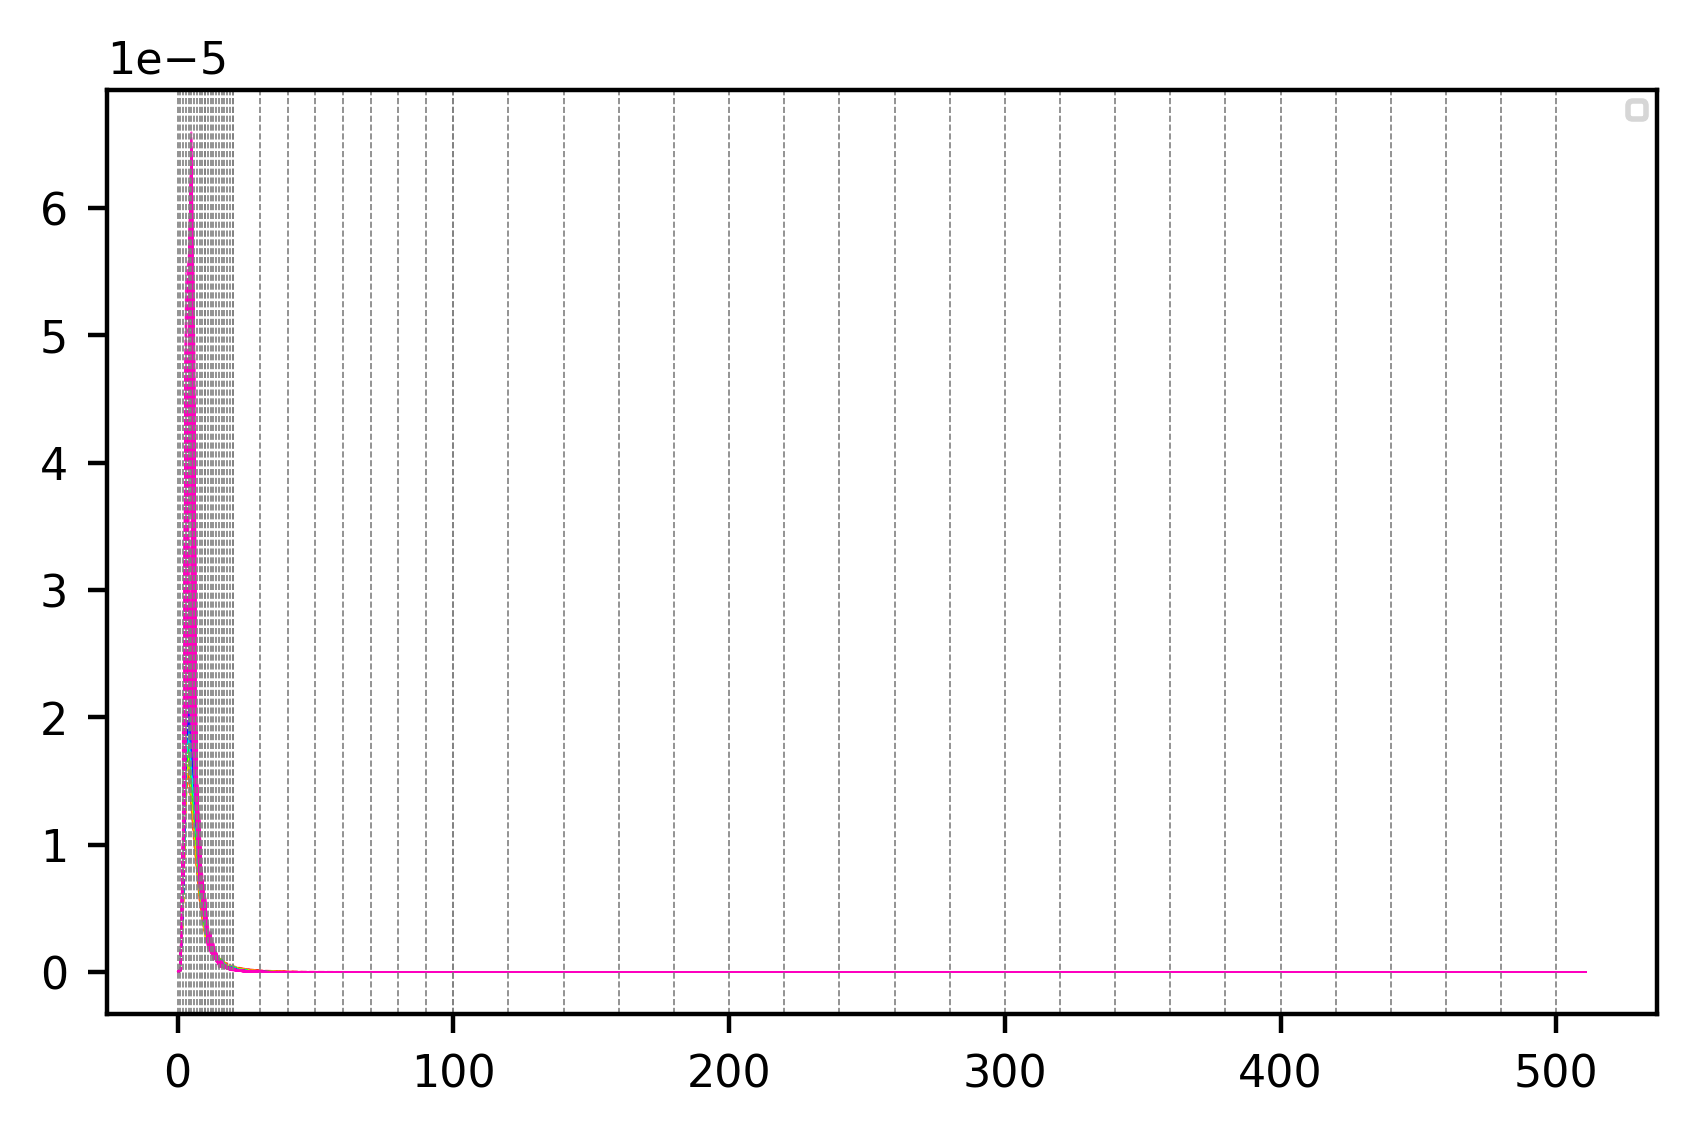

In [9]:
import matplotlib.cm as cm
from scipy.interpolate import interp1d
color_map = plt.cm.gist_rainbow
fig = plt.figure(figsize=[5, 3])
ax = fig.gca()

num_rows = 2
num_cols = 3

kp = 4

N = 1024
L = 2 * np.pi

j = 0

variance_L11 = []
integral_L11 = []
polar_integral_L11 = []

# modes growth
energy_mode_L11 = []
coordx_mode_L11 = []

filtered_coordx_mode = []
filtered_energy_mode = []

for i in range(len(eta_series_L11)):
    eta = eta_series_L11[i]

    k, F_center, F_center_polar_integrated, F_center_polar, k_tile, kxp_tile, kyp_tile, theta_tile, theta, variance, integral, polar_integral, kx, ky = spectrum_integration(
        eta - np.mean(eta), N, L, CHECK=False)
    dk = k[1] - k[0]
    #print(k)
    if i == 0:

        indices1 = np.arange(0, np.where(k >= 1)[0][0], max(1, int(0.25 / dk)))
        indices10 = np.arange(np.where(k >= 1)[0][0], np.where(k >= 10)[0][0], max(1, int(1 / dk)))
        indices1020 = np.arange(np.where(k >= 10)[0][0], np.where(k > 20)[0][0], max(1, int(1 / dk)))
        indices100 = np.arange(np.where(k >= 10)[0][0], np.where(k > 100)[0][0], max(1, int(10/ dk)))
        indicesplus = np.arange(np.where(k >= 100)[0][0], len(k), max(1, int(20 / dk)))

        k_multiples = np.concatenate((indices1, indices10, indices1020 ,indices100, indicesplus))

        k_multiples = k_multiples.astype(int)
        # Obtener los valores de k y las energías correspondientes
        k_seleccionados = k[k_multiples]

    energias_correspondientes_L11 = F_center_polar_integrated[k_multiples]

    
    if i == 0:
        E0_both_L11 = np.sum(F_center_polar_integrated) * dk
        #print(type(indices_cada_diez))
        E0_nodes_both = F_center_polar_integrated[k_multiples]
        #E0_second_both =  F_center_polar_integrated[k_second]
    
    if i % 5 == 0:
        psd = ax.plot(k, F_center_polar_integrated, '--', color=plt.cm.get_cmap('gist_rainbow')(j), alpha=0.7, linewidth=0.3)
    
    
    energy_mode_L11.append(energias_correspondientes_L11.tolist())
    #coordx_mode.append(coordx.tolist())
    
    integral_L11.append(integral)
    j += 1

# plot where are the nodes

for km in k_seleccionados:
    plt.axvline(x=km, color='gray', linestyle='--', linewidth=0.3)
    
ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.legend(loc='upper right', fontsize=4)


color_values =  (np.array(time_L11)-time_L11[0])

# Now set the normalization with the correct range

norm = plt.Normalize(vmin=color_values.min(), vmax=color_values.max())
sm = plt.cm.ScalarMappable(cmap=color_map, norm=norm)
sm.set_array([])  

# Add the colorbar to the figure
cbar = plt.colorbar(sm, orientation='horizontal', pad=0.2)

# Set colorbar label and other properties if needed
cbar.set_label('$\omega_{p} t$')


fig.tight_layout()
cbar.set_label('$\omega_{p} t$')
plt.xscale('log')
#plt.xlim([0,10])
#plt.ylim([10**-8,1])
plt.yscale('log')
plt.xlabel('$\mathdefault{k/k_{p}}$')
plt.ylabel('$\mathdefault{\Phi(k)}$')
fig.tight_layout()

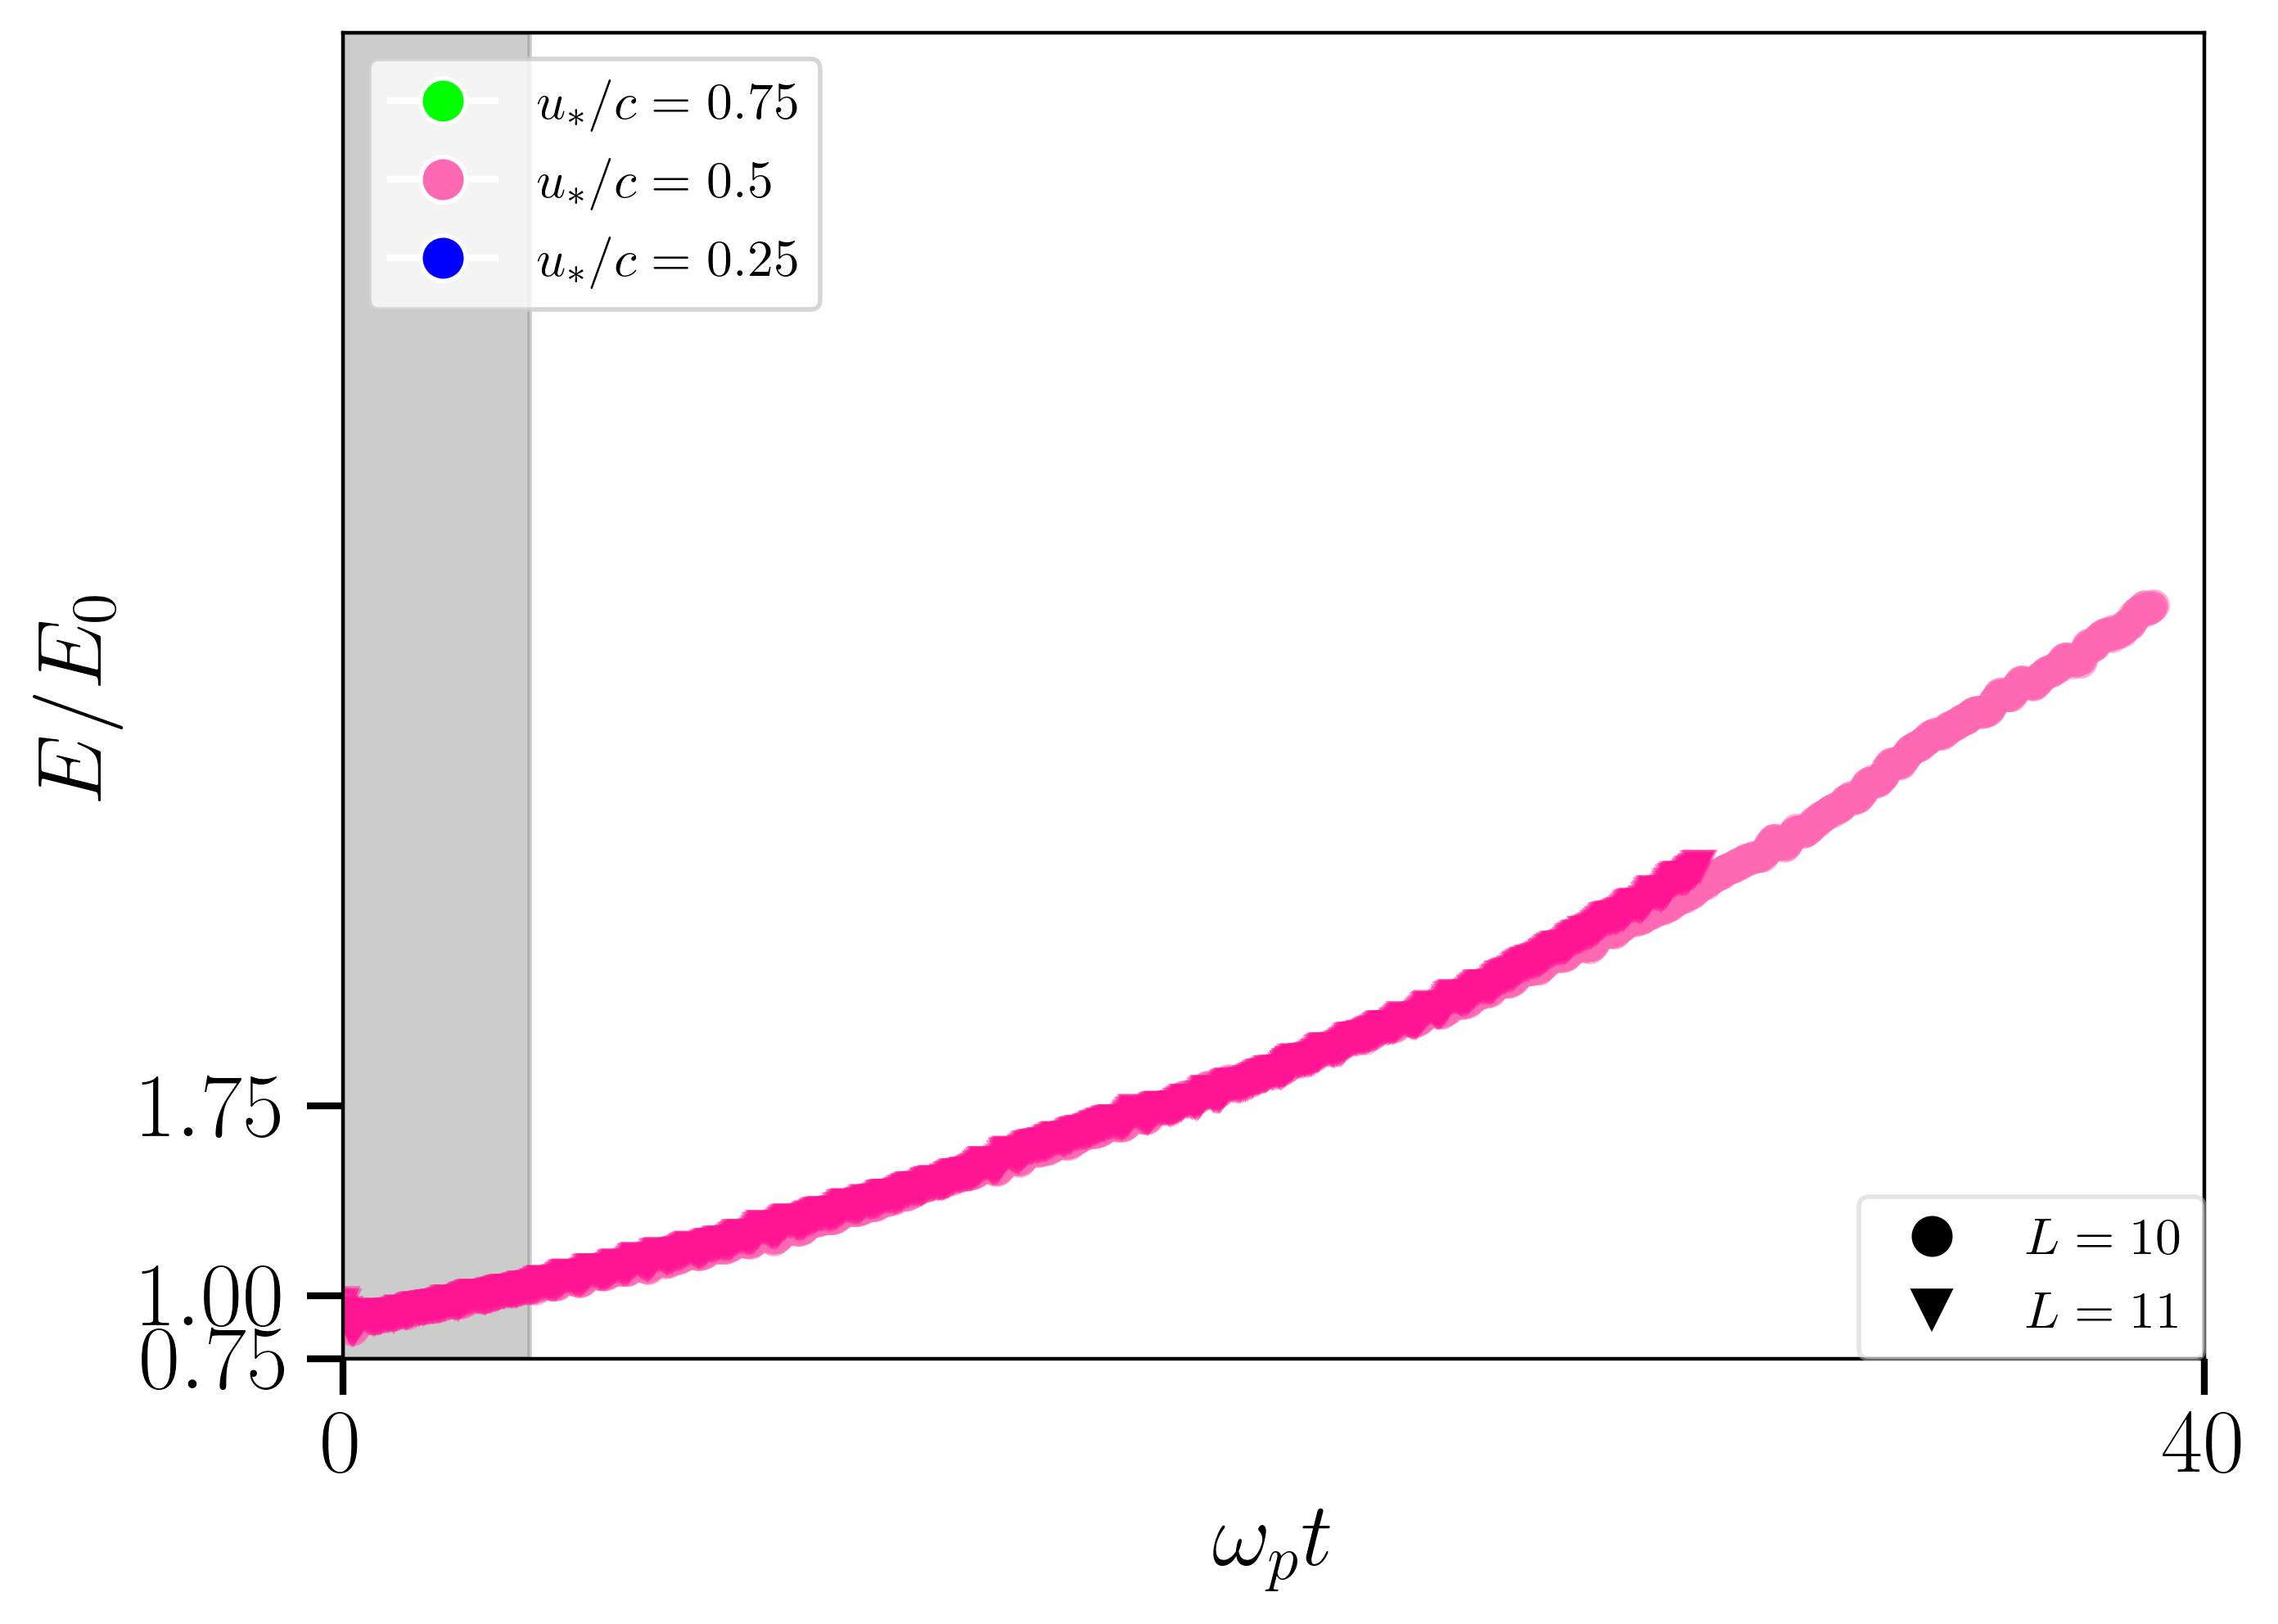

In [10]:
omegap_025 = np.sqrt(4*4)
omegap_05 = np.sqrt(1*4)
omegap_075 = np.sqrt(0.5*4)
tiempo_L10 = []
tiempo_L11 = []
tiempo_L10_uc25 = []
tiempo_L11_uc25 = []
tiempo_uc75 = []


plt.rcParams.update({'legend.fontsize': 'x-Large',
          'figure.figsize': (10, 5),
         'axes.labelsize': 30,
         'axes.titlesize':30,
         'xtick.labelsize':30,
         'ytick.labelsize':30,
    'font.family': 'STIXGeneral',  # Use 'Comic Sans MS' or 'Helvetica' here as needed
    'axes.titleweight': 'normal',
    'axes.labelweight': 'normal',
    'text.usetex': True, # Enable LaTeX rendering
})



# Ahora crea tu figura y ejes
fig, ax = plt.subplots(figsize=(7, 5))  # Usa el tamaño de figura definido en los parámetros


for i in range(len(eta_series_L10)):
    tiempo_L10.append(omegap*(time_L10[i]-time_L10[0])/(2*m.pi))
#print(tiempo_L10)
tiempo_L10 = np.array(tiempo_L10)

for i in range(len(eta_series_L11)):
    tiempo_L11.append(omegap*(time_L11[i]-time_L11[0])/(2*m.pi))

tiempo_L11 = np.array(tiempo_L11)    


# Define los colores y marcadores
color_eta = 'blue'
color_polar = 'green'
color_integral = 'red'
marker_L11 = 'v'  # Marker para Level 11
marker_L10 = 'o'  # Marker para Level 10


plt.plot(tiempo_L10,
         integral_L10/E0_both_L10,
         color='hotpink',     # color para L10 u*/c=0.5
         marker=marker_L10,  
         ls='-', 
         label=r'$u_\ast/c=0.5$', 
         alpha=0.5)


plt.plot(tiempo_L11,
         integral_L11/E0_both_L11,
         color='deeppink',    # color para L11 u*/c=0.5
         marker=marker_L11,
         ls='--',
         label=r'Level 11 $u_\ast/c=0.5$', 
         alpha=0.5)
plt.axvspan(0,4, alpha=0.4, color='grey')
# Ajusta la leyenda y etiquetas
# Añadiendo la leyenda con configuraciones adicionales
legend = ax.legend(loc='upper left',  # Posición de la leyenda
                   frameon=True,     # Desactivar el borde de la leyenda
                   fontsize=10,       # Tamaño de fuente de los textos de la leyenda   
                   title_fontsize=20, # Tamaño de fuente del título de la leyenda
                   shadow=False,       # Sombra para la leyenda
                   ncol=1)            # Número de columnas

ax.set_xlabel(r'$\omega_p t$', fontsize = 20)
ax.set_ylabel(r'$E/E_{0}$', fontsize = 20)
#ax.set_title('Integration energy over Time', pad =20)

ax.tick_params(axis='both', which='major', length=8, width=1.5, labelsize=20)  # Hacer los ticks más grandes
ax.tick_params(axis='both', which='minor', length=4, width=1, labelsize=20)    # Para los ticks menores, si es necesario

# Reducir la cantidad de ticks automáticamente o especificar menos ticks
ax.set_xticks([0, 40, 80])  # Menos ticks en el eje x
ax.set_yticks([0.75, 1.0,  1.75])  # Menos ticks en el eje y

symbols = ['o', 'v']  # Marcadores para L10 y L11
labels = [r'$L=10$', r'$L=11 $']

# Crear objetos de leyenda manualmente para los niveles (L10, L11)
lines = [plt.Line2D([0], [0], marker=s, color='black', linestyle='None', markersize=8) for s in symbols]

# Añadir la primera leyenda para los niveles (L10, L11)
first_legend = plt.legend(lines, labels, loc='lower right', 
                           borderaxespad=0.,
                          facecolor="white", framealpha=0.5, labelcolor='black')
plt.gca().add_artist(first_legend)  # Agregar la leyenda al gráfico

    
branch_color = ['lime',  'hotpink' ,'blue']
branch_labels = [f'$u_*/c=0.75$', f'$u_*/c=0.5$', f'$u_*/c=0.25$']
    
unique_handles = [plt.Line2D([0], [0], marker='o', c= 'w', markerfacecolor=branch_color[i], markersize=10) for i in range(3)]
ax.legend(unique_handles, branch_labels, loc='upper left')

#lgnd.legendHandles[5]._sizes = [30]
plt.ylim([0.75,6])
plt.xlim([0,40])
plt.savefig('/projects/DEIKE/cmartinb/graphs/all_energy.pdf', dpi=600)
plt.savefig(graph_path + f'/all_energy.pdf', dpi=600, bbox_inches='tight')
# Muestra la gráfica
plt.tight_layout()  # Ajusta automáticamente los parámetros de la subtrama para que la subtrama se ajuste al área de la figura
plt.show()

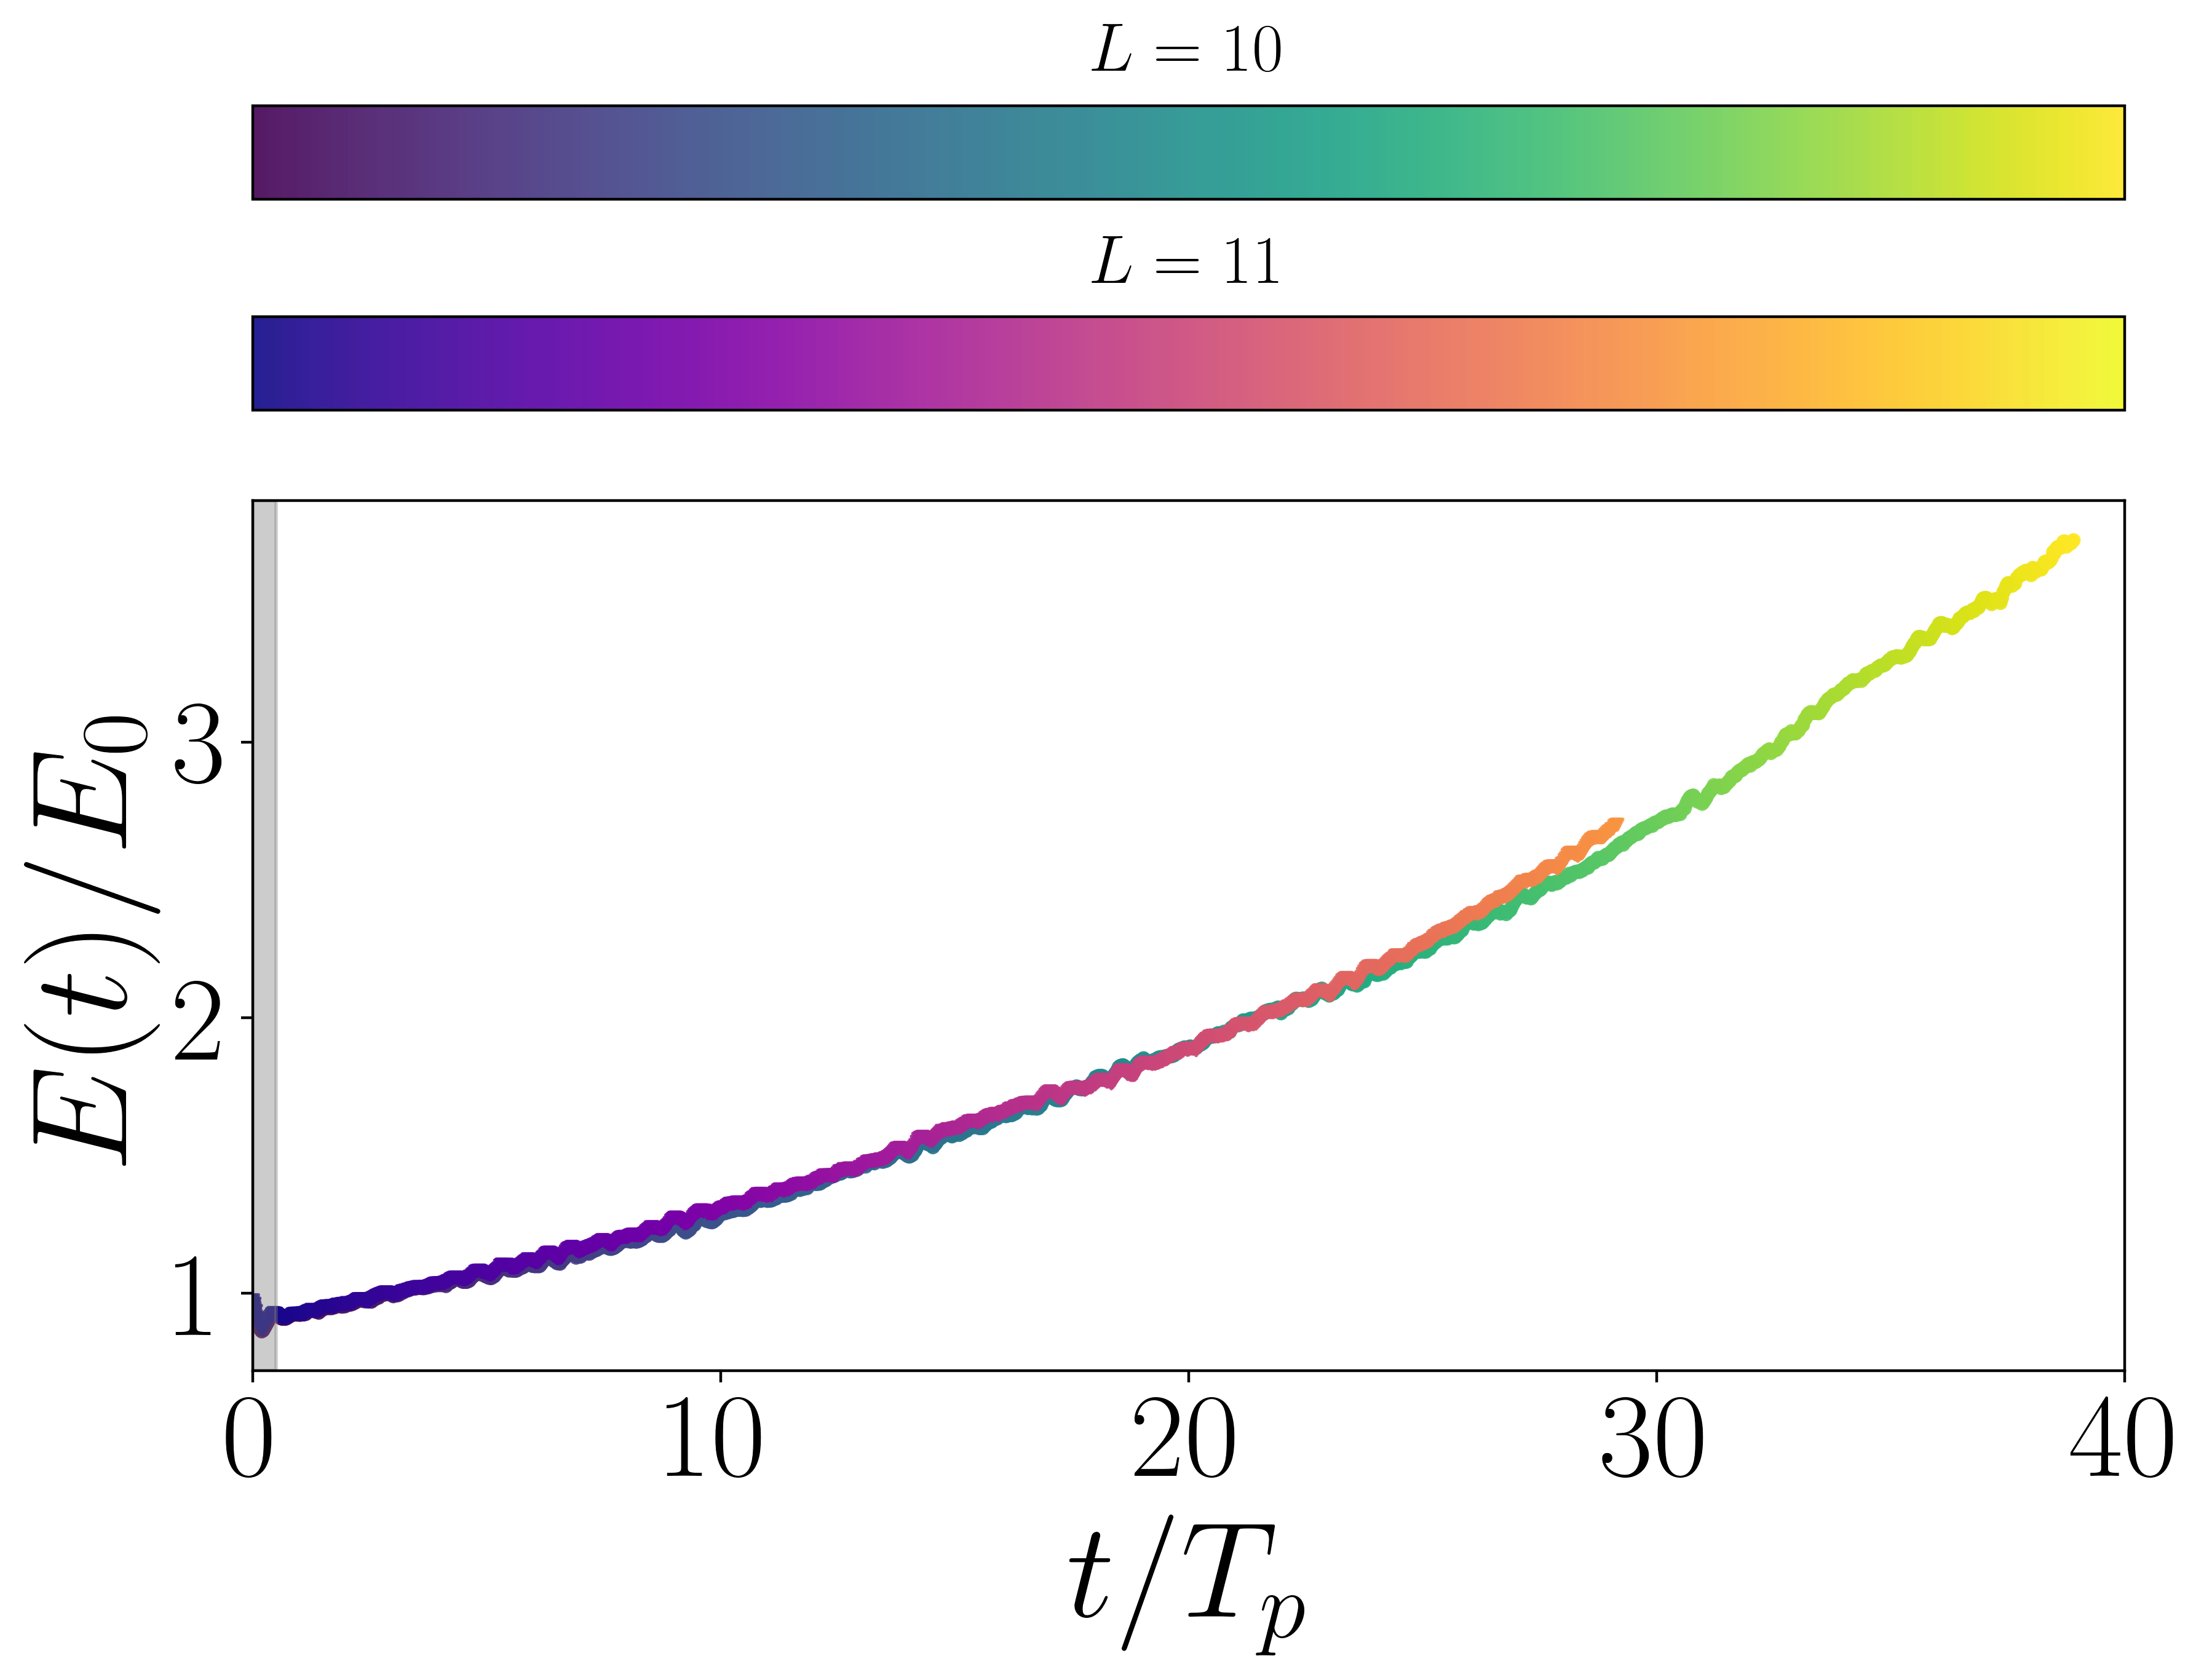

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# =======================
# Estilo global (rcParams)
# =======================
plt.rcParams.update({
    'legend.fontsize': 'x-Large',
    'figure.figsize': (15, 5),
    'axes.labelsize': 30,
    'axes.titlesize': 30,
    'xtick.labelsize': 30,
    'ytick.labelsize': 30,
    'font.family': 'STIXGeneral',
    'axes.titleweight': 'normal',
    'axes.labelweight': 'normal',
    'text.usetex': True,
})

# =====================================
# Datos de ejemplo (reemplaza con los tuyos)
# =====================================
# Tiempo original para L=10 y L=11 (en s)
time_L10 = np.linspace(0, 28, 100)
time_L11 = np.linspace(0, 28, 100)

# Frecuencia de pico (omegap)
omegap = 2 * np.pi  # ejemplo: 1 ciclo/s → 2π rad/s

# =====================================
# Cálculo de t/Tp = (t - t0)*omegap/(2π)
# =====================================
t_norm_L10 = (time_L10 - time_L10[0]) * omegap / (2 * np.pi)
t_norm_L11 = (time_L11 - time_L11[0]) * omegap / (2 * np.pi)

# Normalización común para el colormap
#t_all = np.concatenate(tiempo_L11]
norm = Normalize(vmin=tiempo_L10.min(), vmax=tiempo_L10.max())

# =============================
# Creación de la figura y axes
# =============================
fig, ax = plt.subplots(figsize=(9, 7))

# Scatter para L=10
sc10 = ax.scatter(
    tiempo_L10,
    integral_L10/E0_both_L10,
    c=tiempo_L10,
    cmap='viridis',
    norm=norm,
    s=10,
    marker='o',
    label='L = 10',
    alpha=0.9
)

# Scatter para L=11
sc11 = ax.scatter(
    tiempo_L11,
    integral_L11/E0_both_L11,
    c=tiempo_L11,
    cmap='plasma',
    norm=norm,
    s=10,
    marker='v',
    label='L = 11',
    alpha=0.9
)
plt.axvspan(0,0.5, alpha=0.4, color='grey')
# ====================================
# Primera colorbar (L=10) horizontal arriba
# ====================================
cbar10 = plt.colorbar(
    sc10,
    ax=ax,
    orientation='horizontal',
    pad=0.03,
    location='top'
)
cbar10.set_ticks([])
cbar10.ax.set_title(r'$L=10$', fontsize=20, pad=10)
# ====================================
# Segunda colorbar (L=11), un poco más arriba
# ====================================
cbar11 = plt.colorbar(
    sc11,
    ax=ax,
    orientation='horizontal',
    pad=0.08,            # separada de la anterior
    location='top'
)
cbar11.set_ticks([])
# Título para L=11
cbar11.ax.set_title(r'$L=11$', fontsize=20, pad=10)

# =====================
# Etiquetas y leyenda
# =====================
ax.set_xlabel(r'$t/T_{p}$', fontsize=40)
ax.set_ylabel(r'$E(t)/E_{0}$', fontsize=40)
ax.set_xlim([0, 40])
ax.tick_params(axis='both', which='major', labelsize=35)

# Leyenda de marcadores
#ax.legend(loc='upper right', fontsize=20)
plt.savefig(graph_path + f'/Etime.pdf', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()



<>:84: SyntaxWarning: invalid escape sequence '\m'
<>:85: SyntaxWarning: invalid escape sequence '\m'
<>:84: SyntaxWarning: invalid escape sequence '\m'
<>:85: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_88410/1304954579.py:84: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('$\mathdefault{k/k_{p}}$', fontsize=12)
/tmp/ipykernel_88410/1304954579.py:85: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('$\mathdefault{\phi(k)/ \phi_{0,max}$', fontsize=12)
/tmp/ipykernel_88410/1304954579.py:80: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0, 10)


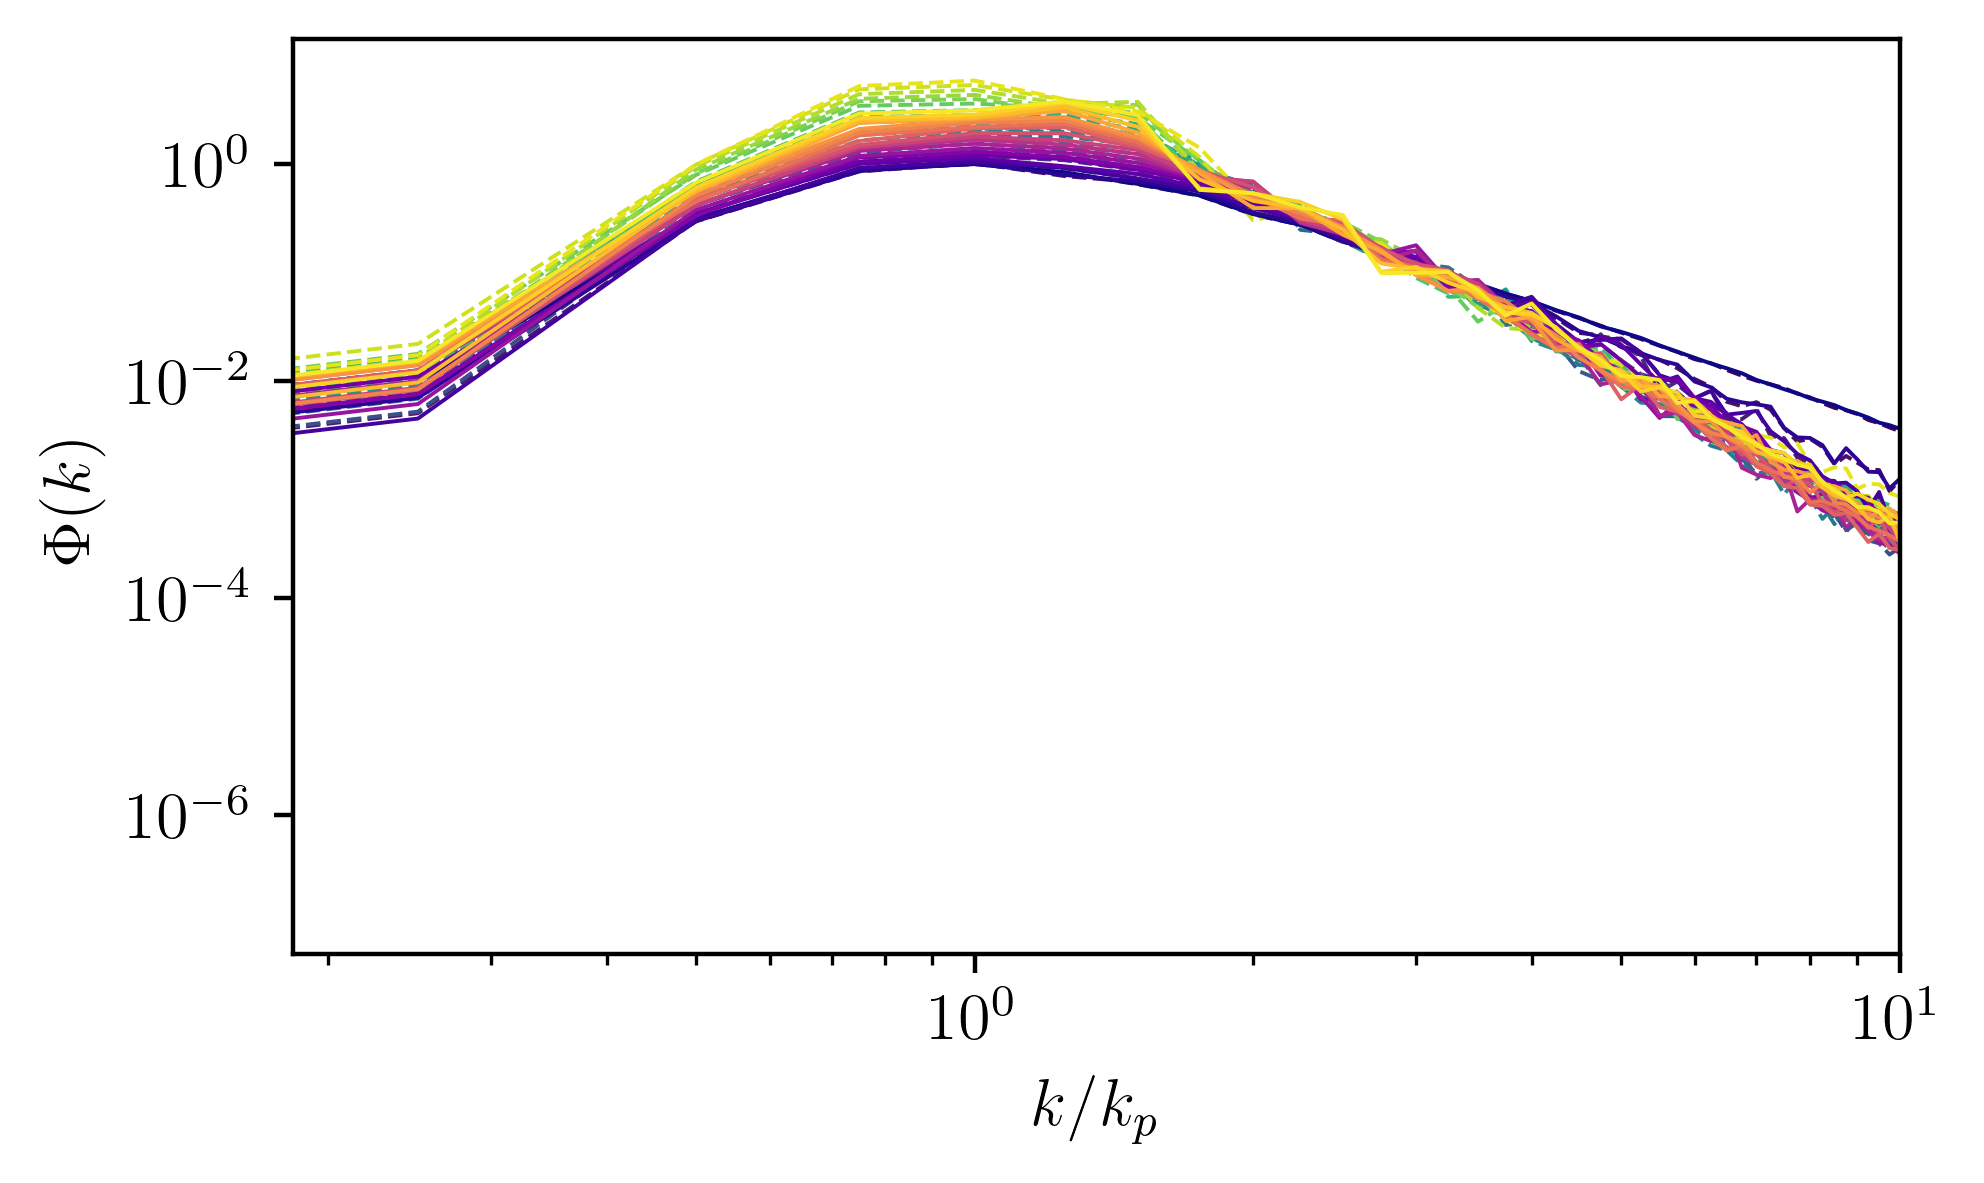

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize#, ScalarMappable
N =512

# Calcula k y k_multiples usando la primera iteración de L10
k0, _, F_center_polar_integrated010, _, _, _, _, _, _, _, _, _, _, _ = spectrum_integration(
    eta_series_L10[0] - np.mean(eta_series_L10[0]), N, L, CHECK=False
)
dk = k0[1] - k0[0]

N=1024

# Calcula k y k_multiples usando la primera iteración de L10
k011, _, F_center_polar_integrated011, _, _, _, _, _, _, _, _, _, _, _ = spectrum_integration(
    eta_series_L11[0] - np.mean(eta_series_L11[0]), N, L, CHECK=False
)

dk = k0[1] - k0[0]

# Normalizaciones de tiempo para colorbars
cv_L10 = tiempo_L10 - tiempo_L10[0]
cv_L11 = tiempo_L11 - tiempo_L11[0]
norm_L10 = Normalize(vmin=cv_L10.min(), vmax=cv_L10.max())
norm_L11 = Normalize(vmin=cv_L11.min(), vmax=cv_L11.max())

# Crea figura y ejes
fig, ax = plt.subplots(figsize=[5, 3])

# — Plot L=10 con viridis —
norm10=np.max(F_center_polar_integrated010)
for i, eta in enumerate(eta_series_L10):
    if i % 50 == 0:
        N=512
        k, F_center, F_center_polar_integrated, F_center_polar, k_tile, kxp_tile, kyp_tile, theta_tile, theta, variance, integral, polar_integral, kx, ky  = spectrum_integration(
            eta - np.mean(eta), N, L, CHECK=False
        )
        color = plt.cm.viridis(norm_L10(cv_L10[i]))
        ax.plot(k/4, F_center_polar_integrated/norm10, '--',
                color=color, alpha=1, linewidth=0.7)

# — Plot L=11 con plasma —
norm11=np.max(F_center_polar_integrated011)
for i, eta in enumerate(eta_series_L11):
    if i % 50 == 0:
        N=1024
        k, F_center, F_center_polar_integrated, F_center_polar, k_tile, kxp_tile, kyp_tile, theta_tile, theta, variance, integral, polar_integral, kx, ky  = spectrum_integration(
            eta - np.mean(eta), N, L, CHECK=False
        )
        color = plt.cm.plasma(norm_L11(cv_L11[i]))
        ax.plot(k/4, F_center_polar_integrated/norm11, '-',
                color=color, alpha=1, linewidth=0.7)

# Líneas verticales en los nodos
#for km in k_seleccionados:
   # ax.axvline(x=km, color='gray', linestyle='--', linewidth=0.3)

ax.yaxis.set_ticks([10**-2, 10**0]) 
# Configuración del tamaño de los números de los ejes
plt.tick_params(axis='both', which='major', labelsize=12)  # Cambiar tamaño de las etiquetas
plt.tick_params(axis='both', which='minor', labelsize=12)  # Opcional: tamaño para etiquetas menores


#plt.hlines(1,0,10, color='gray', linestyle='--', linewidth=2)


fig.tight_layout()
'''
plt.xscale('log')
plt.xlim([0.0000001,10])
plt.yscale('log')
plt.ylim([10**(-4.5),10**(0)])
'''

# 2) then set scales
ax.set_xscale('log')
ax.set_yscale('log')

# 3) then set limits (all positive!)
ax.set_xlim(0, 10)
#ax.set_ylim(10**(-4.5), 10**(0))


plt.xlabel('$\mathdefault{k/k_{p}}$', fontsize=12)
plt.ylabel('$\mathdefault{\phi(k)/ \phi_{0,max}$', fontsize=12)
# Etiquetas
ax.set_xlabel(r'$k/k_p$', fontsize=12)
ax.set_ylabel(r'$\Phi(k)$', fontsize=12)
#plt.savefig(graph_path + f'/energyL10L11.pdf', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()


/tmp/ipykernel_88410/48318140.py:79: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0, 10)


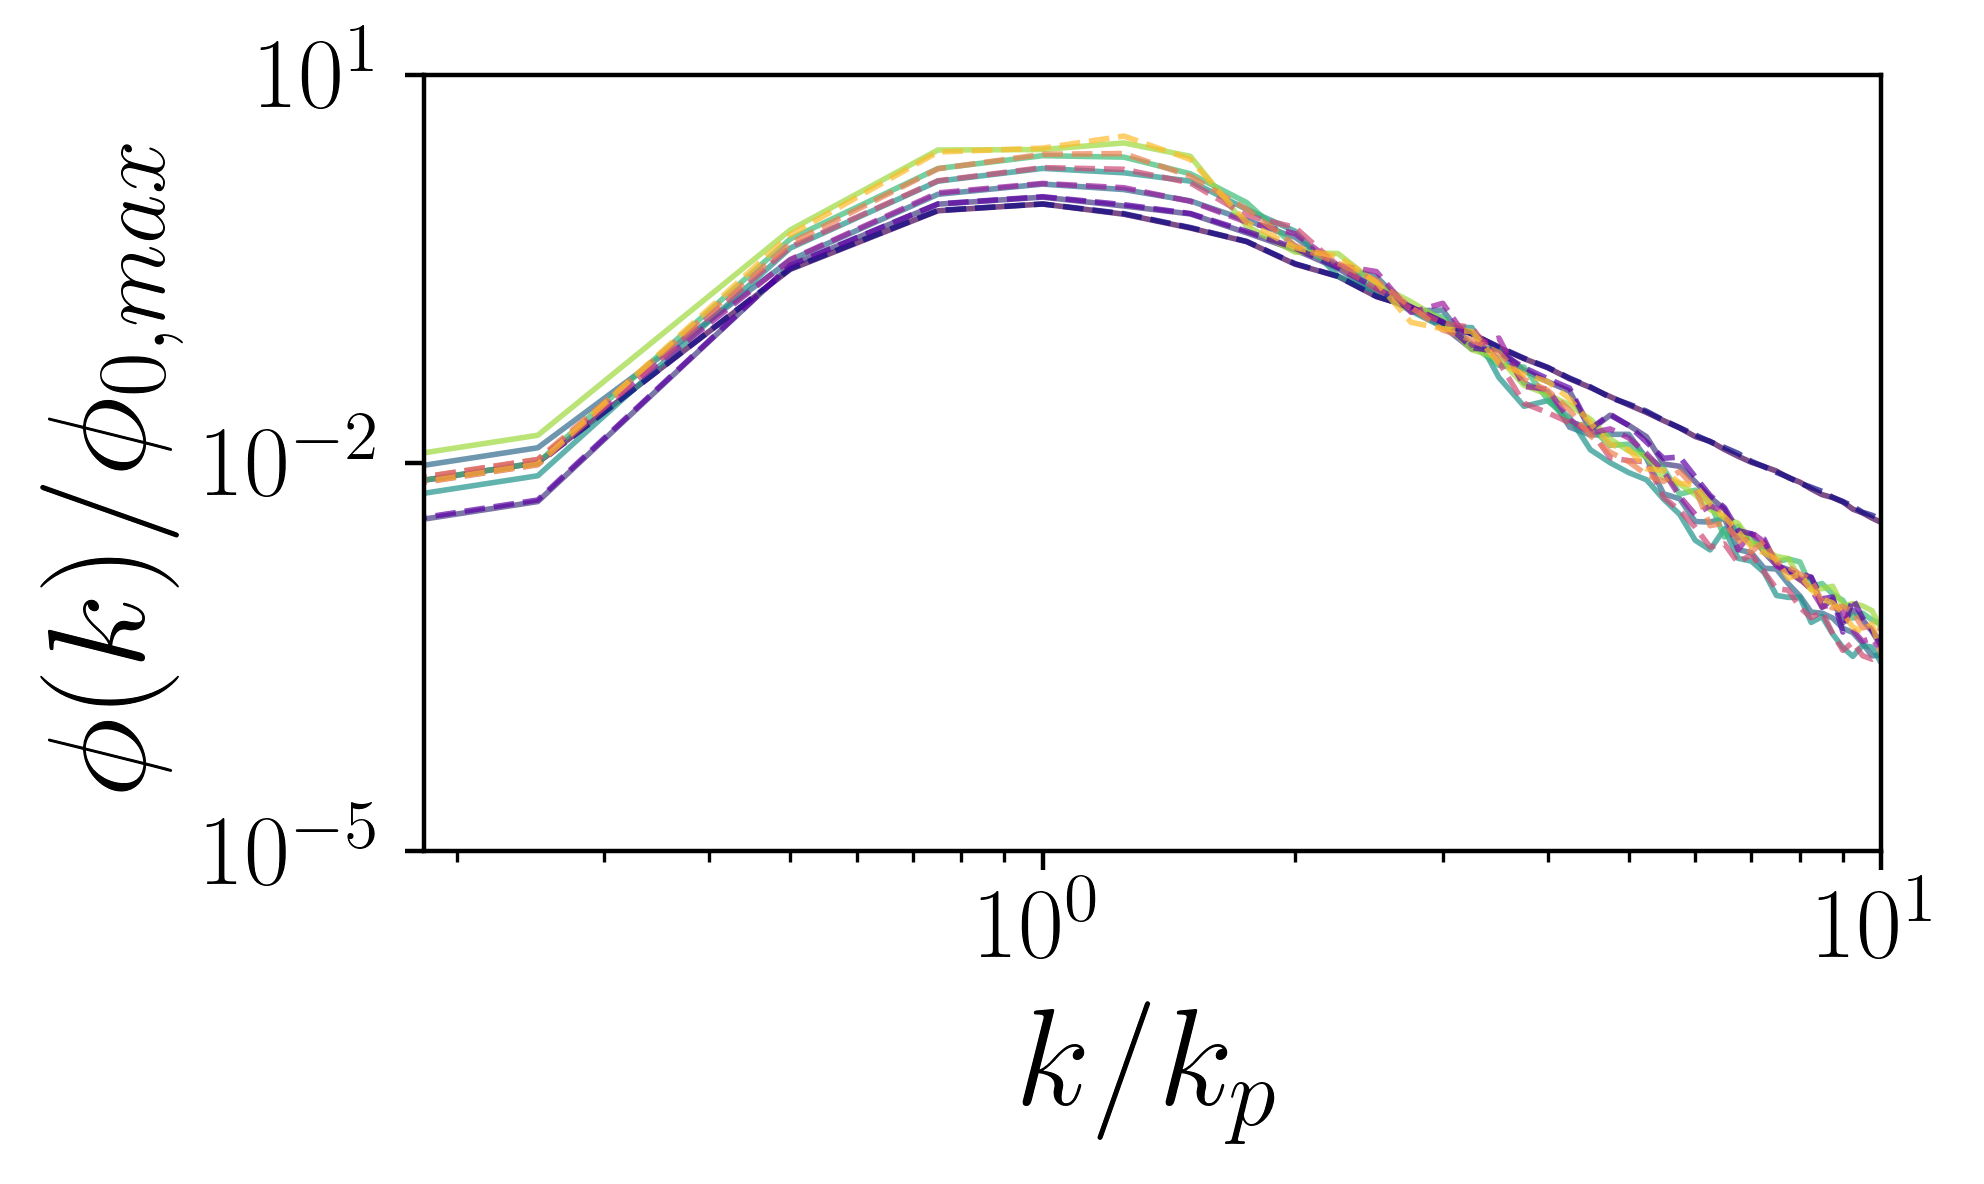

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize#, ScalarMappable
N =512

# Calcula k y k_multiples usando la primera iteración de L10
k0, _, F_center_polar_integrated010, _, _, _, _, _, _, _, _, _, _, _ = spectrum_integration(
    eta_series_L10[0] - np.mean(eta_series_L10[0]), N, L, CHECK=False
)
dk = k0[1] - k0[0]

N=1024

# Calcula k y k_multiples usando la primera iteración de L10
k011, _, F_center_polar_integrated011, _, _, _, _, _, _, _, _, _, _, _ = spectrum_integration(
    eta_series_L11[0] - np.mean(eta_series_L11[0]), N, L, CHECK=False
)

dk = k0[1] - k0[0]

# Normalizaciones de tiempo para colorbars
cv_L10 = tiempo_L10 - tiempo_L10[0]
cv_L11 = tiempo_L11 - tiempo_L11[0]
norm_L10 = Normalize(vmin=cv_L10.min(), vmax=cv_L10.max())
norm_L11 = Normalize(vmin=cv_L11.min(), vmax=cv_L11.max())

# Crea figura y ejes
fig, ax = plt.subplots(figsize=[5, 3])

# — Plot L=10 con viridis 

# — Asegurarnos de que L10 y sus tiempos tengan la misma longitud que L11 —
n = len(eta_series_L11)
eta_series_L10 = eta_series_L10[:n]
tiempo_L10     = tiempo_L10[:n]
cv_L10         = cv_L10[:n]

norm10=np.max(F_center_polar_integrated010)
for i, eta in enumerate(eta_series_L10):
    if i % 160 == 0:
        N=512
        k, F_center, F_center_polar_integrated, F_center_polar, k_tile, kxp_tile, kyp_tile, theta_tile, theta, variance, integral, polar_integral, kx, ky  = spectrum_integration(
            eta - np.mean(eta), N, L, CHECK=False
        )
        color = plt.cm.viridis(norm_L10(cv_L10[i]))
        ax.plot(k/4, F_center_polar_integrated/norm10, '-',
                color=color, alpha=0.7, linewidth=1)

# — Plot L=11 con plasma —
norm11=np.max(F_center_polar_integrated011)
for i, eta in enumerate(eta_series_L11):
    if i % 160 == 0:
        N=1024
        k, F_center, F_center_polar_integrated, F_center_polar, k_tile, kxp_tile, kyp_tile, theta_tile, theta, variance, integral, polar_integral, kx, ky  = spectrum_integration(
            eta - np.mean(eta), N, L, CHECK=False
        )
        color = plt.cm.plasma(norm_L11(cv_L11[i]))
        ax.plot(k/4, F_center_polar_integrated/norm11, '--',
                color=color, alpha=0.7, linewidth=1)

ax.yaxis.set_ticks([10**-5, 10]) 
# Configuración del tamaño de los números de los ejes
plt.tick_params(axis='both', which='major', labelsize=12)  # Cambiar tamaño de las etiquetas
plt.tick_params(axis='both', which='minor', labelsize=12)  # Opcional: tamaño para etiquetas menores

ax.yaxis.set_ticks([10**-2, 10**0]) 
# Configuración del tamaño de los números de los ejes
plt.tick_params(axis='both', which='major', labelsize=18)  # Cambiar tamaño de las etiquetas
plt.tick_params(axis='both', which='minor', labelsize=18)  # Opcional: tamaño para etiquetas menores




# 2) then set scales
ax.set_xscale('log')
ax.set_yscale('log')

# 3) then set limits (all positive!)
ax.set_xlim(0, 10)
ax.set_ylim(10**(-5), 10)


ax.set_xlabel(r'$k/k_{p}$', fontsize=25)
ax.set_ylabel(r'$\phi(k)/ \phi_{0,max}$', fontsize=25)
# Etiquetas
plt.savefig(graph_path + f'/energyL10L11.pdf', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()


In [ ]:
# Cargar eta_series desde un archivo .npy
eta_series_L11_uc25 = np.load('/projects/DEIKE/cmartinb/eta/eta_series_kpHs0p16_uoc0p25_L11.npy', allow_pickle=True)
print(eta_series_L11_uc25.shape)

work_dir_L11_uc25 = '/projects/DEIKE/nscapin/broadband/re720_bo0200_P0p16_uoc0p25_L11/'

#data_L11_uc25 = np.load('/projects/DEIKE/cmartinb/eta/eta_series_kpHs0p16_uoc0p25_L11.npy', 
                        #allow_pickle=True)
data_L11_uc25 = np.loadtxt(work_dir_L11_uc25+'eta/global_int.out')
# Obtener la segunda columna
istep_c_L11_uc25 =data_L11_uc25[:, 1]
#print(istep_c.shape[0])
time_L11_uc25 = data_L11_uc25[:,0] 
#print(time)

In [ ]:
# Cargar eta_series desde un archivo .npy
eta_series_L10_uc25 = np.load('/projects/DEIKE/cmartinb/eta/eta_series_kpHs0p16_uoc0p25.npy', allow_pickle=True)
print(eta_series_L10_uc25.shape)

work_dir_L10_uc25 = '/projects/DEIKE/nscapin/broadband/kpHs0p16_uoc0p25/'

# Leer el archivo de texto
data_L10_uc25 = np.loadtxt(work_dir_L10_uc25+'eta/global_int.out')

# Obtener la segunda columna
istep_c_L10_uc25 =data_L10_uc25[:, 1]
#print(istep_c.shape[0])
time_L10_uc25 = data_L10_uc25[:,0] 
#print(time)

In [ ]:
import matplotlib.cm as cm
from scipy.interpolate import interp1d
color_map = plt.cm.gist_rainbow
fig = plt.figure(figsize=[5, 3])
ax = fig.gca()

num_rows = 2
num_cols = 3

kp = 4

N = 1024
L = 2 * np.pi

j = 0

variance_L11_uc25 = []
integral_L11_uc25 = []
polar_integral_L11_uc25 = []

# modes growth
energy_mode_L11_uc25 = []
coordx_mode_L11_uc25 = []

filtered_coordx_mode = []
filtered_energy_mode = []

for i in range(len(eta_series_L11_uc25)):
    eta = eta_series_L11_uc25[i]

    k, F_center, F_center_polar_integrated, F_center_polar, k_tile, kxp_tile, kyp_tile, theta_tile, theta, variance, integral, polar_integral, kx, ky = spectrum_integration(
        eta - np.mean(eta), N, L, CHECK=False)
    dk = k[1] - k[0]
    #print(k)
    if i == 0:

        indices1 = np.arange(0, np.where(k >= 1)[0][0], max(1, int(0.25 / dk)))
        indices10 = np.arange(np.where(k >= 1)[0][0], np.where(k >= 10)[0][0], max(1, int(1 / dk)))
        indices1020 = np.arange(np.where(k >= 10)[0][0], np.where(k > 20)[0][0], max(1, int(1 / dk)))
        indices100 = np.arange(np.where(k >= 10)[0][0], np.where(k > 100)[0][0], max(1, int(10/ dk)))
        indicesplus = np.arange(np.where(k >= 100)[0][0], len(k), max(1, int(20 / dk)))

        k_multiples = np.concatenate((indices1, indices10, indices1020 ,indices100, indicesplus))

        k_multiples = k_multiples.astype(int)
        # Obtener los valores de k y las energías correspondientes
        k_seleccionados = k[k_multiples]

    energias_correspondientes_L11_uc25 = F_center_polar_integrated[k_multiples]

    
    if i == 0:
        E0_both_L11_uc25 = np.sum(F_center_polar_integrated) * dk
        #print(type(indices_cada_diez))
        E0_nodes_both = F_center_polar_integrated[k_multiples]
        #E0_second_both =  F_center_polar_integrated[k_second]
    
    if i % 5 == 0:
        psd = ax.plot(k, F_center_polar_integrated, '--', color=plt.cm.get_cmap('gist_rainbow')(j), alpha=0.7, linewidth=0.3)
    
    
    energy_mode_L11_uc25.append(energias_correspondientes_L11_uc25.tolist())
    #coordx_mode.append(coordx.tolist())
    
    integral_L11_uc25.append(integral)
    j += 1

# plot where are the nodes

for km in k_seleccionados:
    plt.axvline(x=km, color='gray', linestyle='--', linewidth=0.3)
    
ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.legend(loc='upper right', fontsize=4)


color_values =  (np.array(time_L11_uc25)-time_L11_uc25[0])

# Now set the normalization with the correct range

norm = plt.Normalize(vmin=color_values.min(), vmax=color_values.max())
sm = plt.cm.ScalarMappable(cmap=color_map, norm=norm)
sm.set_array([])  

# Add the colorbar to the figure
cbar = plt.colorbar(sm, orientation='horizontal', pad=0.2)

# Set colorbar label and other properties if needed
cbar.set_label('$\omega_{p} t$')


fig.tight_layout()
cbar.set_label('$\omega_{p} t$')
plt.xscale('log')
#plt.xlim([0,10])
#plt.ylim([10**-8,1])
plt.yscale('log')
plt.xlabel('$\mathdefault{k/k_{p}}$')
plt.ylabel('$\mathdefault{\Phi(k)}$')
fig.tight_layout()

In [ ]:
import matplotlib.cm as cm
from scipy.interpolate import interp1d
color_map = plt.cm.gist_rainbow
fig = plt.figure(figsize=[5, 3])
ax = fig.gca()

num_rows = 2
num_cols = 3

kp = 4

N = 512
L = 2 * np.pi

j = 0




variance_L10_uc25 = []
integral_L10_uc25 = []
polar_integral_L10_uc25 = []

# modes growth
energy_mode_L10_uc25 = []
coordx_mode_L10_uc25 = []

filtered_coordx_mode = []
filtered_energy_mode = []

for i in range(len(eta_series_L10_uc25)):
    eta = eta_series_L10_uc25[i]

    k, F_center, F_center_polar_integrated, F_center_polar, k_tile, kxp_tile, kyp_tile, theta_tile, theta, variance, integral, polar_integral, kx, ky = spectrum_integration(
        eta - np.mean(eta), N, L, CHECK=False)
    dk = k[1] - k[0]
    #print(k)
    if i == 0:

        indices1 = np.arange(0, np.where(k >= 1)[0][0], max(1, int(0.25 / dk)))
        indices10 = np.arange(np.where(k >= 1)[0][0], np.where(k >= 10)[0][0], max(1, int(1 / dk)))
        indices1020 = np.arange(np.where(k >= 10)[0][0], np.where(k > 20)[0][0], max(1, int(1 / dk)))
        indices100 = np.arange(np.where(k >= 10)[0][0], np.where(k > 100)[0][0], max(1, int(10/ dk)))
        indicesplus = np.arange(np.where(k >= 100)[0][0], len(k), max(1, int(20 / dk)))

        k_multiples = np.concatenate((indices1, indices10, indices1020 ,indices100, indicesplus))

        k_multiples = k_multiples.astype(int)
        # Obtener los valores de k y las energías correspondientes
        k_seleccionados = k[k_multiples]

    energias_correspondientes_L10_uc25 = F_center_polar_integrated[k_multiples]

    
    if i == 0:
        E0_both_L10_uc25 = np.sum(F_center_polar_integrated) * dk
        #print(type(indices_cada_diez))
        E0_nodes_both = F_center_polar_integrated[k_multiples]
        #E0_second_both =  F_center_polar_integrated[k_second]
    
    if i % 5 == 0:
        psd = ax.plot(k, F_center_polar_integrated, '--', color=plt.cm.get_cmap('gist_rainbow')(j), alpha=0.7, linewidth=0.3)
    
    
    energy_mode_L10_uc25.append(energias_correspondientes_L10_uc25.tolist())
    #coordx_mode.append(coordx.tolist())
    integral_L10_uc25.append(integral)
 
    j += 1

# plot where are the nodes

for km in k_seleccionados:
    plt.axvline(x=km, color='gray', linestyle='--', linewidth=0.3)
    
ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.legend(loc='upper right', fontsize=4)


color_values =  (np.array(time_L10_uc25)-time_L10_uc25[0])

# Now set the normalization with the correct range

norm = plt.Normalize(vmin=color_values.min(), vmax=color_values.max())
sm = plt.cm.ScalarMappable(cmap=color_map, norm=norm)
sm.set_array([])  

# Add the colorbar to the figure
cbar = plt.colorbar(sm, orientation='horizontal', pad=0.2)

# Set colorbar label and other properties if needed
cbar.set_label('$\omega_{p} t$')


fig.tight_layout()
cbar.set_label('$\omega_{p} t$')
plt.xscale('log')
#plt.xlim([0,10])
#plt.ylim([10**-8,1])
plt.yscale('log')
plt.xlabel('$\mathdefault{k/k_{p}}$')
plt.ylabel('$\mathdefault{\Phi(k)}$')
fig.tight_layout()

In [ ]:
# Cargar eta_series desde un archivo .npy
eta_series_uc75 = np.load('/projects/DEIKE/cmartinb/eta/eta_series_kpHs0p16_uoc0p75.npy', allow_pickle=True)
print(eta_series_uc75.shape)

work_dir_uc75 = '/projects/DEIKE/nscapin/broadband/kpHs0p16_uoc0p75/'

# Leer el archivo de texto
data_uc75 = np.loadtxt(work_dir_uc75+'eta/global_int.out')

# Obtener la segunda columna
istep_c_uc75 =data_uc75[:, 1]
#print(istep_c.shape[0])
time_uc75 = data_uc75[:,0] 
#print(time)

In [ ]:
import matplotlib.cm as cm
from scipy.interpolate import interp1d
color_map = plt.cm.gist_rainbow
fig = plt.figure(figsize=[5, 3])
ax = fig.gca()

num_rows = 2
num_cols = 3

kp = 4

N = 1024
L = 2 * np.pi

j = 0

variance_uc75 = []
integral_uc75 = []
polar_integral_uc75 = []

# modes growth
energy_mode_uc75 = []
coordx_mode_uc75 = []

filtered_coordx_mode = []
filtered_energy_mode = []

for i in range(len(eta_series_uc75)):
    eta = eta_series_uc75[i]

    k, F_center, F_center_polar_integrated, F_center_polar, k_tile, kxp_tile, kyp_tile, theta_tile, theta, variance, integral, polar_integral, kx, ky = spectrum_integration(
        eta - np.mean(eta), N, L, CHECK=False)
    dk = k[1] - k[0]
    #print(k)
    if i == 0:

        indices1 = np.arange(0, np.where(k >= 1)[0][0], max(1, int(0.25 / dk)))
        indices10 = np.arange(np.where(k >= 1)[0][0], np.where(k >= 10)[0][0], max(1, int(1 / dk)))
        indices1020 = np.arange(np.where(k >= 10)[0][0], np.where(k > 20)[0][0], max(1, int(1 / dk)))
        indices100 = np.arange(np.where(k >= 10)[0][0], np.where(k > 100)[0][0], max(1, int(10/ dk)))
        indicesplus = np.arange(np.where(k >= 100)[0][0], len(k), max(1, int(20 / dk)))

        k_multiples = np.concatenate((indices1, indices10, indices1020 ,indices100, indicesplus))

        k_multiples = k_multiples.astype(int)
        # Obtener los valores de k y las energías correspondientes
        k_seleccionados = k[k_multiples]

    energias_correspondientes_uc75 = F_center_polar_integrated[k_multiples]

    
    if i == 0:
        E0_both_uc75 = np.sum(F_center_polar_integrated) * dk
        #print(type(indices_cada_diez))
        E0_nodes_both = F_center_polar_integrated[k_multiples]
        #E0_second_both =  F_center_polar_integrated[k_second]
    
    if i % 5 == 0:
        psd = ax.plot(k, F_center_polar_integrated, '--', color=plt.cm.get_cmap('gist_rainbow')(j), alpha=0.7, linewidth=0.3)
    
    
    energy_mode_uc75.append(energias_correspondientes_uc75.tolist())
    #coordx_mode.append(coordx.tolist())
    integral_uc75.append(integral)
 
    j += 1

# plot where are the nodes

for km in k_seleccionados:
    plt.axvline(x=km, color='gray', linestyle='--', linewidth=0.3)
    
ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.legend(loc='upper right', fontsize=4)


color_values =  (np.array(time_uc75)-time_uc75[0])

# Now set the normalization with the correct range

norm = plt.Normalize(vmin=color_values.min(), vmax=color_values.max())
sm = plt.cm.ScalarMappable(cmap=color_map, norm=norm)
sm.set_array([])  

# Add the colorbar to the figure
cbar = plt.colorbar(sm, orientation='horizontal', pad=0.2)

# Set colorbar label and other properties if needed
cbar.set_label('$\omega_{p} t$')


fig.tight_layout()
cbar.set_label('$\omega_{p} t$')
plt.xscale('log')
#plt.xlim([0,10])
#plt.ylim([10**-8,1])
plt.yscale('log')
plt.xlabel('$\mathdefault{k/k_{p}}$')
plt.ylabel('$\mathdefault{\Phi(k)}$')
fig.tight_layout()

In [ ]:
omegap_025 = np.sqrt(4*4)
omegap_05 = np.sqrt(1*4)
omegap_075 = np.sqrt(0.5*4)
tiempo_L10 = []
tiempo_L11 = []
tiempo_L10_uc25 = []
tiempo_L11_uc25 = []
tiempo_uc75 = []


plt.rcParams.update({'legend.fontsize': 'x-Large',
          'figure.figsize': (10, 5),
         'axes.labelsize': 30,
         'axes.titlesize':30,
         'xtick.labelsize':30,
         'ytick.labelsize':30,
    'font.family': 'STIXGeneral',  # Use 'Comic Sans MS' or 'Helvetica' here as needed
    'axes.titleweight': 'normal',
    'axes.labelweight': 'normal',
    'text.usetex': True, # Enable LaTeX rendering
})



# Ahora crea tu figura y ejes
fig, ax = plt.subplots(figsize=(7, 5))  # Usa el tamaño de figura definido en los parámetros


for i in range(len(eta_series_L10)):
    tiempo_L10.append(omegap*(time_L10[i]-time_L10[0]))
#print(tiempo_L10)
tiempo_L10 = np.array(tiempo_L10)

for i in range(len(eta_series_L11)):
    tiempo_L11.append(omegap*(time_L11[i]-time_L11[0]))    

tiempo_L11 = np.array(tiempo_L11)    
    
for i in range(len(eta_series_L10_uc25)):
    tiempo_L10_uc25.append(omegap_025*(time_L10_uc25[i]-time_L10_uc25[0]))   
    
tiempo_L10_uc25 = np.array(tiempo_L10_uc25)   

for i in range(len(eta_series_L11_uc25)):
    tiempo_L11_uc25.append(omegap_025*(time_L11_uc25[i]-time_L11_uc25[0]))   
tiempo_L11_uc25 = np.array(tiempo_L11_uc25)   


for i in range(len(eta_series_uc75)):
    tiempo_uc75.append(omegap_075*(time_uc75[i]-time_uc75[0]))
tiempo_uc75 = np.array(tiempo_uc75)  


# Define los colores y marcadores
color_eta = 'blue'
color_polar = 'green'
color_integral = 'red'
marker_L11 = 'v'  # Marker para Level 11
marker_L10 = 'o'  # Marker para Level 10


#print(integral_L10_uc25.shape)
#print(tiempo_L10_uc25, np.array(integral_L10_uc25),type(tiempo_L10_uc25), type(integral_L10_uc25/E0_both_L10_uc25) )
# Sustituimos plt.scatter() por plt.plot()
plt.plot(tiempo_uc75,
         integral_uc75/E0_both_uc75,
         color='lime',       # color para u*/c=0.75
         marker=marker_L10,  # L10 lo representamos con este marcador
         ls='-',             # línea continua para "L10" (o el caso que corresponda)
         label=r'$u_\ast/c=0.75$', 
         alpha=0.5)

plt.plot(tiempo_L11_uc25,
         integral_L11_uc25/E0_both_L11_uc25,
         color='navy',        # color para L11 u*/c=0.25
         marker=marker_L11, 
         ls='--',             # línea discontinua para L11
         label=r'Level 11 $u_\ast/c=0.25$',  
         alpha=0.5)

plt.plot(tiempo_L10,
         integral_L10/E0_both_L10,
         color='hotpink',     # color para L10 u*/c=0.5
         marker=marker_L10,  
         ls='-', 
         label=r'$u_\ast/c=0.5$', 
         alpha=0.5)

plt.plot(tiempo_L10_uc25,
         integral_L10_uc25/E0_both_L10_uc25,
         color='aqua',        # color para L10 u*/c=0.25
         marker=marker_L10,  
         ls='-', 
         label=r'$u_\ast/c=0.25$', 
         alpha=0.5)

plt.plot(tiempo_L11,
         integral_L11/E0_both_L11,
         color='deeppink',    # color para L11 u*/c=0.5
         marker=marker_L11,
         ls='--',
         label=r'Level 11 $u_\ast/c=0.5$', 
         alpha=0.5)
plt.axvspan(0,4, alpha=0.4, color='grey')
# Ajusta la leyenda y etiquetas
# Añadiendo la leyenda con configuraciones adicionales
legend = ax.legend(loc='upper left',  # Posición de la leyenda
                   frameon=True,     # Desactivar el borde de la leyenda
                   fontsize=10,       # Tamaño de fuente de los textos de la leyenda   
                   title_fontsize=20, # Tamaño de fuente del título de la leyenda
                   shadow=False,       # Sombra para la leyenda
                   ncol=1)            # Número de columnas

ax.set_xlabel(r'$\omega_p t$', fontsize = 20)
ax.set_ylabel(r'$E/E_{0}$', fontsize = 20)
#ax.set_title('Integration energy over Time', pad =20)

ax.tick_params(axis='both', which='major', length=8, width=1.5, labelsize=20)  # Hacer los ticks más grandes
ax.tick_params(axis='both', which='minor', length=4, width=1, labelsize=20)    # Para los ticks menores, si es necesario

# Reducir la cantidad de ticks automáticamente o especificar menos ticks
ax.set_xticks([0, 40, 80])  # Menos ticks en el eje x
ax.set_yticks([0.75, 1.0,  1.75])  # Menos ticks en el eje y

symbols = ['o', 'v']  # Marcadores para L10 y L11
labels = [r'$L=10$', r'$L=11 $']

# Crear objetos de leyenda manualmente para los niveles (L10, L11)
lines = [plt.Line2D([0], [0], marker=s, color='black', linestyle='None', markersize=8) for s in symbols]

# Añadir la primera leyenda para los niveles (L10, L11)
first_legend = plt.legend(lines, labels, loc='lower right', 
                           borderaxespad=0.,
                          facecolor="white", framealpha=0.5, labelcolor='black')
plt.gca().add_artist(first_legend)  # Agregar la leyenda al gráfico

    
branch_color = ['lime',  'hotpink' ,'blue']
branch_labels = [f'$u_*/c=0.75$', f'$u_*/c=0.5$', f'$u_*/c=0.25$']
    
unique_handles = [plt.Line2D([0], [0], marker='o', c= 'w', markerfacecolor=branch_color[i], markersize=10) for i in range(3)]
ax.legend(unique_handles, branch_labels, loc='upper left')

#lgnd.legendHandles[5]._sizes = [30]
plt.ylim([0.75,1.75])
#plt.xlim([0,30])
plt.savefig('/projects/DEIKE/cmartinb/graphs/all_energy.png', dpi=400)
# Muestra la gráfica
plt.tight_layout()  # Ajusta automáticamente los parámetros de la subtrama para que la subtrama se ajuste al área de la figura
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Ejemplo de frecuencias calculadas (cambia los valores según corresponda a tu caso real)
omegap_025 = np.sqrt(4*4)
omegap_05  = np.sqrt(1*4)
omegap_075 = np.sqrt(0.5*4)

# Listas vacías para tiempos (sólo como ejemplo)
tiempo_L10        = []
tiempo_L11        = []
tiempo_L10_uc25   = []
tiempo_L11_uc25   = []
tiempo_uc75       = []

# --- (Aquí tu código para cargar eta_series, time, etc.) ---

##############################################################################
# Configuración general de estilo
##############################################################################
plt.rcParams.update({
    'legend.fontsize': 'x-Large',
    'figure.figsize': (10, 5),
    'axes.labelsize': 30,
    'axes.titlesize': 30,
    'xtick.labelsize': 30,
    'ytick.labelsize': 30,
    'font.family': 'STIXGeneral',
    'axes.titleweight': 'normal',
    'axes.labelweight': 'normal',
    'text.usetex': True,  # Habilitar LaTeX
})

# Crear figura y ejes
fig, ax = plt.subplots(figsize=(15, 7))

##############################################################################
# Cálculo de tiempos reescalados (ejemplo)
##############################################################################
# Suponiendo que omegap es la frecuencia de referencia para el caso sin subíndice
omegap = np.sqrt(2*4)  # Valor de ejemplo

for i in range(len(eta_series_L10)):
    tiempo_L10.append(omegap * (time_L10[i] - time_L10[0]))
tiempo_L10 = np.array(tiempo_L10)

for i in range(len(eta_series_L11)):
    tiempo_L11.append(omegap * (time_L11[i] - time_L11[0]))
tiempo_L11 = np.array(tiempo_L11)

for i in range(len(eta_series_L10_uc25)):
    tiempo_L10_uc25.append(omegap_025 * (time_L10_uc25[i] - time_L10_uc25[0]))
tiempo_L10_uc25 = np.array(tiempo_L10_uc25)

for i in range(len(eta_series_L11_uc25)):
    tiempo_L11_uc25.append(omegap_025 * (time_L11_uc25[i] - time_L11_uc25[0]))
tiempo_L11_uc25 = np.array(tiempo_L11_uc25)

for i in range(len(eta_series_uc75)):
    tiempo_uc75.append(omegap_075 * (time_uc75[i] - time_uc75[0]))
tiempo_uc75 = np.array(tiempo_uc75)

##############################################################################
# Definir colores y marcadores diferenciados
##############################################################################
marker_L10_025 = 'o'
color_L10_025  = 'royalblue'

marker_L11_025 = 's'
color_L11_025  = 'darkblue'

marker_L10_05  = '^'
color_L10_05   = 'darkorange'

marker_L11_05  = 'D'
color_L11_05   = 'red'

marker_uc75    = 'v'
color_uc75     = 'green'

##############################################################################
# Graficar cada serie con un color/marker único
##############################################################################
# Ejemplo de graficación con scatter:
plt.scatter(tiempo_uc75 - 10,
            integral_uc75 / E0_both_uc75,
            s=60, color=color_uc75, marker=marker_uc75,
            label=r'$u_\ast/c=0.75$',
            alpha=0.7)

plt.scatter(tiempo_L11_uc25 - 10,
            integral_L11_uc25 / E0_both_L11_uc25,
            s=60, color=color_L11_025, marker=marker_L11_025,
            label=r'L11, $u_\ast/c=0.25$',
            alpha=0.7)

plt.scatter(tiempo_L10 - 10,
            integral_L10 / E0_both_L10,
            s=60, color=color_L10_05, marker=marker_L10_05,
            label=r'L10, $u_\ast/c=0.50$',
            alpha=0.7)

plt.scatter(tiempo_L10_uc25 - 10,
            integral_L10_uc25 / E0_both_L10_uc25,
            s=60, color=color_L10_025, marker=marker_L10_025,
            label=r'L10, $u_\ast/c=0.25$',
            alpha=0.7)

plt.scatter(tiempo_L11 - 10,
            integral_L11 / E0_both_L11,
            s=60, color=color_L11_05, marker=marker_L11_05,
            label=r'L11, $u_\ast/c=0.50$',
            alpha=0.7)

##############################################################################
# Ajuste de ejes, leyenda y apariencia
##############################################################################
legend = ax.legend(loc='upper left',
                   frameon=True,
                   fontsize=20,
                   shadow=False,
                   ncol=1)

ax.set_xlabel(r'$\omega_p t$', fontsize=35)
ax.set_ylabel(r'$E/E_{0}$', fontsize=35)

ax.tick_params(axis='both', which='major', length=8, width=1.5, labelsize=35)
ax.tick_params(axis='both', which='minor', length=4, width=1, labelsize=35)

# Ejemplo de pocos ticks en los ejes
ax.set_xticks([0, 40, 80])
ax.set_yticks([0.75, 1.0, 1.75])

# Ajustar tamaños de los puntos en la leyenda (opcional)
for handle in legend.legendHandles:
    handle.set_sizes([60])  # o el tamaño que desees

plt.ylim([0.75, 1.75])
plt.xlim([0, 50])

plt.tight_layout()
plt.savefig('/projects/DEIKE/cmartinb/graphs/all_energy.png', dpi=400)
plt.show()
